<a href="https://colab.research.google.com/github/HenryZumaeta/MDS_UNI/blob/Zeta/CICLO02/DL/C01_20230403_Caso_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go

from google.colab import files #Librería para cargar ficheros directamente en Colab
%matplotlib inline

In [ ]:
# Necesitaremos montar su disco usando los siguientes comandos:
# Para obtener más información sobre el montaje, puedes consultar: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#sales_df = pd.read_csv('/content/drive/My Drive/Curso de Masterclass en IA Moderna/3. Marketing AI/sales_data_sample.csv', encoding = 'unicode_escape')
# Nota: MSRP es el precio minorista sugerido por el fabricante (MSRP) o el precio de etiqueta representa el precio minorista sugerido de los productos.
# El MSRP se utiliza para estandarizar el precio de los productos en varias ubicaciones de tiendas de la empresa.

In [2]:
link = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRarGef71ZJHlqc7dSwrhZExyW2FxulKLQ3Rs3qo792VCoJnd1w2oNswteccHxNhUUEHe72zI-ZPtH7/pub?gid=10493905&single=true&output=csv"
sales_df = pd.read_csv(link, encoding="unicode_escape")

In [3]:
sales_df.head(3)

ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   

        ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0  2/24/2003 0:00  Shipped       1         2     2003  ...   
1   5/7/2003 0:00  Shipped       2         5     2003  ...   
2   7/1/2003 0:00  Shipped       3         7     2003  ...   

                    ADDRESSLINE1  ADDRESSLINE2   CITY STATE POSTALCODE  \
0        897 Long Airport Avenue           NaN    NYC    NY      10022   
1             59 rue de l'Abbaye           NaN  Reims   NaN      51100   
2  27 rue du Colonel Pierre Avia           NaN  Paris   NaN      75508   

  COUNTRY TERRITORY CONTACTLASTNAME CONTACTFIRSTNAME DEALSIZE  
0     USA       NaN              Yu             Kwai    Small  
1  France      EMEA         Henriot             Paul    Small  
2  France      EMEA        Da Cunha           Daniel   Medium  

[3 rows x 25 columns]

In [4]:
# Veamos los tipos de datos
sales_df.dtypes

ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
PHONE                object
ADDRESSLINE1         object
ADDRESSLINE2         object
CITY                 object
STATE                object
POSTALCODE           object
COUNTRY              object
TERRITORY            object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

MINI RETO #1:
- Convertir la fecha del pedido en formato de fecha y hora usando `pandas`.
- Verificar que la conversión es correcta imprimiendo el tipo de datos

In [5]:
# Convertir la fecha del pedido en formato de fecha y hora
sales_df['ORDERDATE'] = pd.to_datetime(sales_df['ORDERDATE'])
# Comprobar el tipo de datos
sales_df.dtypes

ORDERNUMBER                  int64
QUANTITYORDERED              int64
PRICEEACH                  float64
ORDERLINENUMBER              int64
SALES                      float64
ORDERDATE           datetime64[ns]
STATUS                      object
QTR_ID                       int64
MONTH_ID                     int64
YEAR_ID                      int64
PRODUCTLINE                 object
MSRP                         int64
PRODUCTCODE                 object
CUSTOMERNAME                object
PHONE                       object
ADDRESSLINE1                object
ADDRESSLINE2                object
CITY                        object
STATE                       object
POSTALCODE                  object
COUNTRY                     object
TERRITORY                   object
CONTACTLASTNAME             object
CONTACTFIRSTNAME            object
DEALSIZE                    object
dtype: object

MINI RETO #2:
- ¿Cuántos elementos nulos existen en 'ADDRESSLINE2'?

<Axes: >

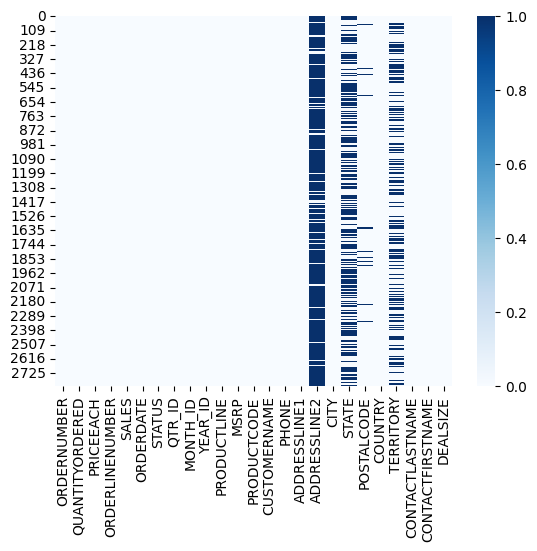

In [6]:
# Veamos si nos faltan datos, ¡afortunadamente NO!
sns.heatmap(sales_df.isnull() ,  cmap="Blues")

<Axes: >

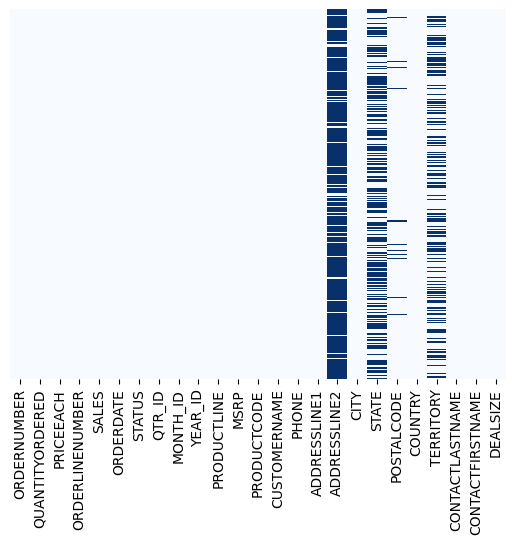

In [7]:
# Veamos si nos faltan datos, ¡afortunadamente NO!
sns.heatmap(sales_df.isnull() , yticklabels = False, cbar = False, cmap="Blues")

In [8]:

# Comprobar el número de elementos nulos del data frame
sales_df.isnull().sum()

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [9]:
sales_df.shape

(2823, 25)

In [10]:
df_drop  = ['ADDRESSLINE1', 'ADDRESSLINE2', 'POSTALCODE', 'CITY', 'TERRITORY', 'PHONE', 'STATE', 'CONTACTFIRSTNAME', 'CONTACTLASTNAME', 'CUSTOMERNAME', 'ORDERNUMBER']
sales_df = sales_df.drop(df_drop, axis = 1)

In [11]:
sales_df.head(3)

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  ORDERDATE   STATUS  \
0               30      95.70                2  2871.00 2003-02-24  Shipped   
1               34      81.35                5  2765.90 2003-05-07  Shipped   
2               41      94.74                2  3884.34 2003-07-01  Shipped   

   QTR_ID  MONTH_ID  YEAR_ID  PRODUCTLINE  MSRP PRODUCTCODE COUNTRY DEALSIZE  
0       1         2     2003  Motorcycles    95    S10_1678     USA    Small  
1       2         5     2003  Motorcycles    95    S10_1678  France    Small  
2       3         7     2003  Motorcycles    95    S10_1678  France   Medium

In [12]:
sales_df.shape

(2823, 14)

In [13]:
sales_df.isnull().sum()

QUANTITYORDERED    0
PRICEEACH          0
ORDERLINENUMBER    0
SALES              0
ORDERDATE          0
STATUS             0
QTR_ID             0
MONTH_ID           0
YEAR_ID            0
PRODUCTLINE        0
MSRP               0
PRODUCTCODE        0
COUNTRY            0
DEALSIZE           0
dtype: int64

MINI RETO #3:
- ¿Cuántos valores únicos existen en 'país'?
- ¿Cuántos códigos de producto únicos y líneas de productos tenemos?

In [14]:
# Obtener las observaciones únicas de cada columna
sales_df.nunique()

QUANTITYORDERED      58
PRICEEACH          1016
ORDERLINENUMBER      18
SALES              2763
ORDERDATE           252
STATUS                6
QTR_ID                4
MONTH_ID             12
YEAR_ID               3
PRODUCTLINE           7
MSRP                 80
PRODUCTCODE         109
COUNTRY              19
DEALSIZE              3
dtype: int64

In [ ]:
# TAREA #3: ANALISIS EXPLORATORIO DE LOS DATOS Y LIMPIEZA - PARTE 1

In [15]:
sales_df['COUNTRY'].value_counts()

COUNTRY
USA            1004
Spain           342
France          314
Australia       185
UK              144
Italy           113
Finland          92
Norway           85
Singapore        79
Canada           70
Denmark          63
Germany          62
Sweden           57
Austria          55
Japan            52
Belgium          33
Switzerland      31
Philippines      26
Ireland          16
Name: count, dtype: int64

In [16]:
sales_df['COUNTRY'].value_counts().index

Index(['USA', 'Spain', 'France', 'Australia', 'UK', 'Italy', 'Finland',
       'Norway', 'Singapore', 'Canada', 'Denmark', 'Germany', 'Sweden',
       'Austria', 'Japan', 'Belgium', 'Switzerland', 'Philippines', 'Ireland'],
      dtype='object', name='COUNTRY')

In [17]:
  fig = plt.Figure(figsize = (12, 6))
  fig = px.bar(x=sales_df['COUNTRY'].value_counts().index, y=sales_df['COUNTRY'].value_counts(),color=sales_df['COUNTRY'].value_counts().index, height=600)
  fig.show()

In [18]:
# Función para visualizar el recuento de elementos en una columna determinada
# Ten en cuenta que Plotly es una librería de gráficos de Python que crea gráficos interactivos con calidad de publicación.
# Compruébalo en: https://plotly.com/python/
# Nota: px (plotly_express) es un wrapper de alto nivel entorno a plotly para una rápida exploración de datos y generación de figuras
# Compruébalo en: https://plotly.github.io/plotly_express

def barplot_visualization(x):
  fig = plt.Figure(figsize = (12, 6))
  fig = px.bar(x = sales_df[x].value_counts().index, y = sales_df[x].value_counts(), color = sales_df[x].value_counts().index, height = 600)
  fig.show()

In [19]:
barplot_visualization('DEALSIZE')

In [20]:
barplot_visualization('MONTH_ID')

In [21]:
barplot_visualization('STATUS')

In [22]:
sales_df.drop(columns= ['STATUS'], inplace = True)
sales_df

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  ORDERDATE  QTR_ID  \
0                  30      95.70                2  2871.00 2003-02-24       1   
1                  34      81.35                5  2765.90 2003-05-07       2   
2                  41      94.74                2  3884.34 2003-07-01       3   
3                  45      83.26                6  3746.70 2003-08-25       3   
4                  49     100.00               14  5205.27 2003-10-10       4   
...               ...        ...              ...      ...        ...     ...   
2818               20     100.00               15  2244.40 2004-12-02       4   
2819               29     100.00                1  3978.51 2005-01-31       1   
2820               43     100.00                4  5417.57 2005-03-01       1   
2821               34      62.24                1  2116.16 2005-03-28       1   
2822               47      65.52                9  3079.44 2005-05-06       2   

      MONTH_ID  YEAR_ID  PRODUCTLINE  MSRP PRODUCTCODE  COUNTRY DEALSIZE  
0            2     2003  Motorcycles    95    S10_1678      USA    Small  
1            5     2003  Motorcycles    95    S10_1678   France    Small  
2            7     2003  Motorcycles    95    S10_1678   France   Medium  
3            8     2003  Motorcycles    95    S10_1678      USA   Medium  
4           10     2003  Motorcycles    95    S10_1678      USA   Medium  
...        ...      ...          ...   ...         ...      ...      ...  
2818        12     2004        Ships    54    S72_3212    Spain    Small  
2819         1     2005        Ships    54    S72_3212  Finland   Medium  
2820         3     2005        Ships    54    S72_3212    Spain   Medium  
2821         3     2005        Ships    54    S72_3212   France    Small  
2822         5     2005        Ships    54    S72_3212      USA   Medium  

[2823 rows x 13 columns]

In [23]:
barplot_visualization('PRODUCTLINE')

In [24]:
sales_df['DEALSIZE']

0        Small
1        Small
2       Medium
3       Medium
4       Medium
         ...  
2818     Small
2819    Medium
2820    Medium
2821     Small
2822    Medium
Name: DEALSIZE, Length: 2823, dtype: object

In [25]:
dummy = pd.get_dummies(sales_df['DEALSIZE'])
dummy

Large  Medium  Small
0     False   False   True
1     False   False   True
2     False    True  False
3     False    True  False
4     False    True  False
...     ...     ...    ...
2818  False   False   True
2819  False    True  False
2820  False    True  False
2821  False   False   True
2822  False    True  False

[2823 rows x 3 columns]

In [26]:
def dummies(x):
  dummy = pd.get_dummies(sales_df[x])
  sales_df.drop(columns = x , inplace = True)
  return pd.concat([sales_df, dummy], axis = 1)

In [27]:
# Obtengamos variables ficticias para la columna 'PAÍS'
sales_df = dummies('COUNTRY')
sales_df.head(3)

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  ORDERDATE  QTR_ID  \
0               30      95.70                2  2871.00 2003-02-24       1   
1               34      81.35                5  2765.90 2003-05-07       2   
2               41      94.74                2  3884.34 2003-07-01       3   

   MONTH_ID  YEAR_ID  PRODUCTLINE  MSRP  ...  Italy  Japan  Norway  \
0         2     2003  Motorcycles    95  ...  False  False   False   
1         5     2003  Motorcycles    95  ...  False  False   False   
2         7     2003  Motorcycles    95  ...  False  False   False   

   Philippines  Singapore  Spain  Sweden  Switzerland     UK    USA  
0        False      False  False   False        False  False   True  
1        False      False  False   False        False  False  False  
2        False      False  False   False        False  False  False  

[3 rows x 31 columns]

In [28]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   QUANTITYORDERED  2823 non-null   int64         
 1   PRICEEACH        2823 non-null   float64       
 2   ORDERLINENUMBER  2823 non-null   int64         
 3   SALES            2823 non-null   float64       
 4   ORDERDATE        2823 non-null   datetime64[ns]
 5   QTR_ID           2823 non-null   int64         
 6   MONTH_ID         2823 non-null   int64         
 7   YEAR_ID          2823 non-null   int64         
 8   PRODUCTLINE      2823 non-null   object        
 9   MSRP             2823 non-null   int64         
 10  PRODUCTCODE      2823 non-null   object        
 11  DEALSIZE         2823 non-null   object        
 12  Australia        2823 non-null   bool          
 13  Austria          2823 non-null   bool          
 14  Belgium          2823 non-null   bool   

In [29]:
sales_df = dummies('PRODUCTLINE')
sales_df.head(4)

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  ORDERDATE  QTR_ID  \
0               30      95.70                2  2871.00 2003-02-24       1   
1               34      81.35                5  2765.90 2003-05-07       2   
2               41      94.74                2  3884.34 2003-07-01       3   
3               45      83.26                6  3746.70 2003-08-25       3   

   MONTH_ID  YEAR_ID  MSRP PRODUCTCODE  ... Switzerland     UK    USA  \
0         2     2003    95    S10_1678  ...       False  False   True   
1         5     2003    95    S10_1678  ...       False  False  False   
2         7     2003    95    S10_1678  ...       False  False  False   
3         8     2003    95    S10_1678  ...       False  False   True   

   Classic Cars  Motorcycles  Planes  Ships  Trains  Trucks and Buses  \
0         False         True   False  False   False             False   
1         False         True   False  False   False             False   
2         False         True   False  False   False             False   
3         False         True   False  False   False             False   

   Vintage Cars  
0         False  
1         False  
2         False  
3         False  

[4 rows x 37 columns]

In [30]:
sales_df = dummies('DEALSIZE')


In [31]:
sales_df.head(3)

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  ORDERDATE  QTR_ID  \
0               30      95.70                2  2871.00 2003-02-24       1   
1               34      81.35                5  2765.90 2003-05-07       2   
2               41      94.74                2  3884.34 2003-07-01       3   

   MONTH_ID  YEAR_ID  MSRP PRODUCTCODE  ...  Classic Cars  Motorcycles  \
0         2     2003    95    S10_1678  ...         False         True   
1         5     2003    95    S10_1678  ...         False         True   
2         7     2003    95    S10_1678  ...         False         True   

   Planes  Ships  Trains  Trucks and Buses  Vintage Cars  Large  Medium  Small  
0   False  False   False             False         False  False   False   True  
1   False  False   False             False         False  False   False   True  
2   False  False   False             False         False  False    True  False  

[3 rows x 39 columns]

In [32]:
y = pd.Categorical(sales_df['PRODUCTCODE'])
y

['S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', ..., 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212']
Length: 2823
Categories (109, object): ['S10_1678', 'S10_1949', 'S10_2016', 'S10_4698', ..., 'S700_3962',
                           'S700_4002', 'S72_1253', 'S72_3212']

In [33]:
y = pd.Categorical(sales_df['PRODUCTCODE']).codes
y

array([  0,   0,   0, ..., 108, 108, 108], dtype=int8)

In [34]:
# Dado que el número de código de producto tiene 109 valores únicos, si agregamos variables one-hot,
# serían 109 columnas adicionales, podemos evitarlo usando la codificación categórica
# Esta no es la forma óptima de lidiar con esto, pero es importante evitar la maldición de la dimensionalidad.
sales_df['PRODUCTCODE'] = pd.Categorical(sales_df['PRODUCTCODE']).codes

In [35]:
sales_df.tail(3)

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  ORDERDATE  QTR_ID  \
2820               43     100.00                4  5417.57 2005-03-01       1   
2821               34      62.24                1  2116.16 2005-03-28       1   
2822               47      65.52                9  3079.44 2005-05-06       2   

      MONTH_ID  YEAR_ID  MSRP  PRODUCTCODE  ...  Classic Cars  Motorcycles  \
2820         3     2005    54          108  ...         False        False   
2821         3     2005    54          108  ...         False        False   
2822         5     2005    54          108  ...         False        False   

      Planes  Ships  Trains  Trucks and Buses  Vintage Cars  Large  Medium  \
2820   False   True   False             False         False  False    True   
2821   False   True   False             False         False  False   False   
2822   False   True   False             False         False  False    True   

      Small  
2820  False  
2821   True  
2822  False  

[3 rows x 39 columns]

In [36]:
# Agrupamos los datos según la fecha del pedido
sales_df_group = sales_df.groupby(by = "ORDERDATE").sum()
sales_df_group.head(5)

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER     SALES  QTR_ID  \
ORDERDATE                                                                   
2003-01-06              151     288.78               10  12133.25       4   
2003-01-09              142     284.96               10  11432.34       4   
2003-01-10               80     150.14                3   6864.05       2   
2003-01-29              541    1417.54              136  54702.00      16   
2003-01-31              443    1061.89               91  44621.96      13   

            MONTH_ID  YEAR_ID  MSRP  PRODUCTCODE  Australia  ...  \
ORDERDATE                                                    ...   
2003-01-06         4     8012   363          174          0  ...   
2003-01-09         4     8012   372          181          0  ...   
2003-01-10         2     4006   155           37          0  ...   
2003-01-29        16    32048  1695          723          0  ...   
2003-01-31        13    26039  1365          720          0  ...   

            Classic Cars  Motorcycles  Planes  Ships  Trains  \
ORDERDATE                                                      
2003-01-06             0            0       0      0       0   
2003-01-09             0            0       0      0       0   
2003-01-10             0            0       0      0       0   
2003-01-29             3            0       0      0       0   
2003-01-31             7            0       0      0       2   

            Trucks and Buses  Vintage Cars  Large  Medium  Small  
ORDERDATE                                                         
2003-01-06                 0             4      0       2      2  
2003-01-09                 0             4      0       2      2  
2003-01-10                 0             2      0       1      1  
2003-01-29                 7             6      0      10      6  
2003-01-31                 4             0      0       8      5  

[5 rows x 38 columns]

In [37]:
px.line(x = sales_df_group.index, y = sales_df_group.SALES, title = 'Sales')

In [38]:
sales_df_group.index

DatetimeIndex(['2003-01-06', '2003-01-09', '2003-01-10', '2003-01-29',
               '2003-01-31', '2003-02-11', '2003-02-17', '2003-02-24',
               '2003-03-03', '2003-03-10',
               ...
               '2005-05-03', '2005-05-05', '2005-05-06', '2005-05-09',
               '2005-05-10', '2005-05-13', '2005-05-17', '2005-05-29',
               '2005-05-30', '2005-05-31'],
              dtype='datetime64[ns]', name='ORDERDATE', length=252, freq=None)

MINI RETO #6:
- Según los datos, ¿cuándo alcanzan su punto máximo las ventas (en qué mes)?
- Apoya tu respuesta con visualizaciones / gráficos

In [39]:
# Podemos eliminar 'ORDERDATE' y quedarnos con el resto de datos relacionados con la fecha como 'MONTH'
sales_df.drop("ORDERDATE", axis = 1, inplace = True)
sales_df.shape

(2823, 38)

MINI RETO #7:
- Representar la matriz de correlación entre variables.
- Comentar los resultados de la matriz.

<Axes: >

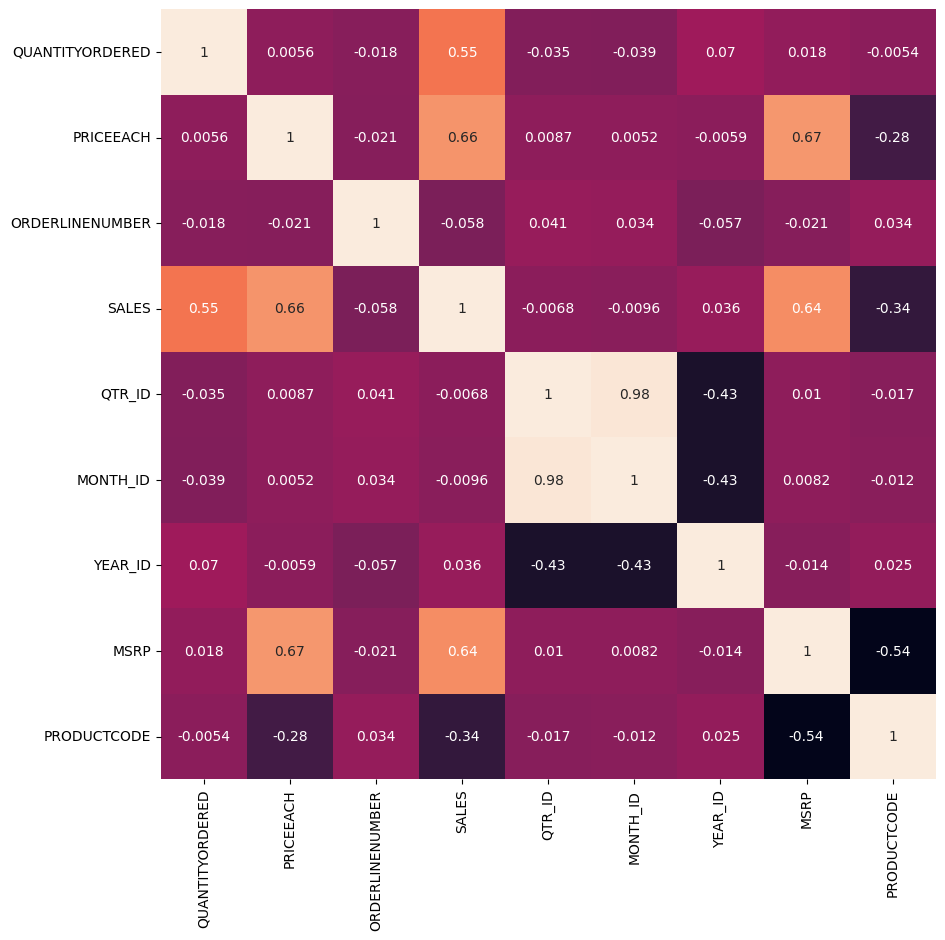

In [41]:
plt.figure(figsize = (10, 10))
corr_matrix = sales_df.iloc[:, :9].corr()
sns.heatmap(corr_matrix, annot = True, cbar = False)

In [42]:
# Parece que el ID del trimestre y los ID del mes están altamente correlacionados
# Dejemos 'QTR_ID' (o 'MONTH_ID')
sales_df.drop("QTR_ID", axis = 1, inplace = True)
sales_df.shape

(2823, 37)

In [43]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   QUANTITYORDERED   2823 non-null   int64  
 1   PRICEEACH         2823 non-null   float64
 2   ORDERLINENUMBER   2823 non-null   int64  
 3   SALES             2823 non-null   float64
 4   MONTH_ID          2823 non-null   int64  
 5   YEAR_ID           2823 non-null   int64  
 6   MSRP              2823 non-null   int64  
 7   PRODUCTCODE       2823 non-null   int8   
 8   Australia         2823 non-null   bool   
 9   Austria           2823 non-null   bool   
 10  Belgium           2823 non-null   bool   
 11  Canada            2823 non-null   bool   
 12  Denmark           2823 non-null   bool   
 13  Finland           2823 non-null   bool   
 14  France            2823 non-null   bool   
 15  Germany           2823 non-null   bool   
 16  Ireland           2823 non-null   bool   


In [44]:
# Vamos a representar distribuciones
# Distplot muestra el (1) histograma, (2) kde plot y (3) rug plot.
# (1) Histograma: es una visualización gráfica de datos que usa barras con varias alturas. Cada barra agrupa los números en rangos y las barras más altas muestran que hay más datos en ese rango.
# (2) Densidad: la estimación de la función de densidad se utiliza para visualizar la densidad de probabilidad de una variable continua.
# (3) Gráfico de alfombra: gráfico de datos para una única variable cuantitativa, que se muestra como marcas a lo largo de un eje (gráfico de dispersión unidimensional).

import plotly.figure_factory as ff

plt.figure(figsize = (10, 10))

for i in range(8):
  if sales_df.columns[i] != 'ORDERLINENUMBER':
    col_name = sales_df.columns[i]
    fig = ff.create_distplot([sales_df[col_name].apply(lambda x: float(x))], ['distplot'])
    fig.update_layout(title_text = col_name)
    fig.show()

<Figure size 1000x1000 with 0 Axes>

In [45]:
# Visualizar la relación entre variables usando parcelas
plt.figure(figsize = (15, 15))

fig = px.scatter_matrix(sales_df,
    dimensions = sales_df.columns[:8], color = 'MONTH_ID')

fig.update_layout(
    title = 'Sales Data',
    width = 1100,
    height = 1100,
)
fig.show()

# Existe una tendencia entre 'SALES' y 'QUANTITYORDERED'
# Existe una tendencia entre 'MSRP' y 'PRICEEACH'
# Existe una tendencia entre 'PRICEEACH' y 'SALES'
# Parece que el crecimiento de las ventas se nota a medida que pasamos de 2013 a 2014 y a 2015 ('VENTAS' frente a 'YEAR_ID')
# Si hacemos zoom en 'VENTAS' y 'CANTIDAD ORDENADA', se puede ver la información mensual codificada por colores en el gráfico


<Figure size 1500x1500 with 0 Axes>

# TAREA #6: ENCUENTRE EL NÚMERO ÓPTIMO DE CLUSTERS UTILIZANDO EL MÉTODO DE CODO

- El método del codo es un método heurístico de interpretación y validación de la coherencia dentro del análisis de conglomerados diseñado para ayudar a encontrar el número apropiado de clusters en un conjunto de datos.
- Si el gráfico de líneas se parece a un brazo, entonces el "codo" en el brazo es el valor de k que es el mejor.
- Fuente:
  - https://en.wikipedia.org/wiki/Elbow_method_(clustering)
  - https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

Explicación prática distribución z - campana de Gauss
https://drive.google.com/drive/folders/1CSR8UMwNqsja5F_EJ-ijSGQ52ZAHsVHu?usp=sharing

In [46]:
# Escalamos los datos
scaler = StandardScaler()
sales_df_scaled = scaler.fit_transform(sales_df)

In [47]:
 sales_df_scaled.shape

(2823, 37)

In [48]:
 sales_df_scaled

array([[-0.52289086,  0.5969775 , -1.05705871, ..., -0.24267205,
        -0.98070333,  1.09637041],
       [-0.11220131, -0.11445035, -0.34701507, ..., -0.24267205,
        -0.98070333,  1.09637041],
       [ 0.60650538,  0.54938372, -1.05705871, ..., -0.24267205,
         1.01967636, -0.9121005 ],
       ...,
       [ 0.81185016,  0.81015797, -0.58369628, ..., -0.24267205,
         1.01967636, -0.9121005 ],
       [-0.11220131, -1.06186404, -1.29373992, ..., -0.24267205,
        -0.98070333,  1.09637041],
       [ 1.2225397 , -0.89925195,  0.59970978, ..., -0.24267205,
         1.01967636, -0.9121005 ]])

In [49]:
list(sales_df.columns)

['QUANTITYORDERED',
 'PRICEEACH',
 'ORDERLINENUMBER',
 'SALES',
 'MONTH_ID',
 'YEAR_ID',
 'MSRP',
 'PRODUCTCODE',
 'Australia',
 'Austria',
 'Belgium',
 'Canada',
 'Denmark',
 'Finland',
 'France',
 'Germany',
 'Ireland',
 'Italy',
 'Japan',
 'Norway',
 'Philippines',
 'Singapore',
 'Spain',
 'Sweden',
 'Switzerland',
 'UK',
 'USA',
 'Classic Cars',
 'Motorcycles',
 'Planes',
 'Ships',
 'Trains',
 'Trucks and Buses',
 'Vintage Cars',
 'Large',
 'Medium',
 'Small']

In [50]:
# convertimos el arreglo de datos escalados (z = (x-u)/s) para ver los datos convertidos a la nueva escala
data_df = pd.DataFrame(sales_df_scaled, columns=sales_df.columns)

In [51]:
data_df.head(4)

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER     SALES  MONTH_ID  YEAR_ID  \
0        -0.522891   0.596978        -1.057059 -0.370825 -1.392909 -1.16517   
1        -0.112201  -0.114450        -0.347015 -0.427897 -0.572337 -1.16517   
2         0.606505   0.549384        -1.057059  0.179443 -0.025289 -1.16517   
3         1.017195  -0.019759        -0.110334  0.104701  0.248235 -1.16517   

       MSRP  PRODUCTCODE  Australia   Austria  ...  Classic Cars  Motorcycles  \
0 -0.142246     -1.70278  -0.264819 -0.140961  ...     -0.721812     2.743848   
1 -0.142246     -1.70278  -0.264819 -0.140961  ...     -0.721812     2.743848   
2 -0.142246     -1.70278  -0.264819 -0.140961  ...     -0.721812     2.743848   
3 -0.142246     -1.70278  -0.264819 -0.140961  ...     -0.721812     2.743848   

     Planes     Ships    Trains  Trucks and Buses  Vintage Cars     Large  \
0 -0.348674 -0.300637 -0.167454          -0.34547     -0.523371 -0.242672   
1 -0.348674 -0.300637 -0.167454          -0.34547     -0.523371 -0.242672   
2 -0.348674 -0.300637 -0.167454          -0.34547     -0.523371 -0.242672   
3 -0.348674 -0.300637 -0.167454          -0.34547     -0.523371 -0.242672   

     Medium    Small  
0 -0.980703  1.09637  
1 -0.980703  1.09637  
2  1.019676 -0.91210  
3  1.019676 -0.91210  

[4 rows x 37 columns]

In [52]:
# Sacamos los estadísticos, para ver la media que debe ser 0 (eje 3.282296e-16 = 0) en la data escalada (eje z de la campana de Gauss) y desviación estándar de 1
data_df.describe()

QUANTITYORDERED     PRICEEACH  ORDERLINENUMBER         SALES  \
count     2.823000e+03  2.823000e+03     2.823000e+03  2.823000e+03   
mean      3.347580e-16 -3.221731e-16     9.312817e-17  1.812224e-16   
std       1.000177e+00  1.000177e+00     1.000177e+00  1.000177e+00   
min      -2.987028e+00 -2.814902e+00    -1.293740e+00 -1.668039e+00   
25%      -8.309080e-01 -7.336653e-01    -8.203775e-01 -7.333318e-01   
50%      -9.528928e-03  5.969775e-01    -1.103339e-01 -2.004243e-01   
75%       8.118502e-01  8.101580e-01     5.997098e-01  5.181052e-01   
max       6.356159e+00  8.101580e-01     2.729841e+00  5.717453e+00   

           MONTH_ID       YEAR_ID          MSRP   PRODUCTCODE     Australia  \
count  2.823000e+03  2.823000e+03  2.823000e+03  2.823000e+03  2.823000e+03   
mean  -1.761884e-17 -1.988412e-15  8.054328e-17 -8.054328e-17 -8.306026e-17   
std    1.000177e+00  1.000177e+00  1.000177e+00  1.000177e+00  1.000177e+00   
min   -1.666433e+00 -1.165170e+00 -1.685272e+00 -1.702780e+00 -2.648186e-01   
25%   -8.458608e-01 -1.165170e+00 -8.142087e-01 -8.478006e-01 -2.648186e-01   
50%    2.482354e-01  2.643280e-01 -4.269579e-02 -2.448696e-02 -2.648186e-01   
75%    1.068808e+00  2.643280e-01  5.794920e-01  8.621585e-01 -2.648186e-01   
max    1.342332e+00  1.693826e+00  2.819368e+00  1.717138e+00  3.776170e+00   

            Austria  ...  Classic Cars   Motorcycles        Planes  \
count  2.823000e+03  ...  2.823000e+03  2.823000e+03  2.823000e+03   
mean  -2.516977e-18  ... -2.013582e-17 -1.208149e-16 -4.027164e-17   
std    1.000177e+00  ...  1.000177e+00  1.000177e+00  1.000177e+00   
min   -1.409608e-01  ... -7.218123e-01 -3.644517e-01 -3.486736e-01   
25%   -1.409608e-01  ... -7.218123e-01 -3.644517e-01 -3.486736e-01   
50%   -1.409608e-01  ... -7.218123e-01 -3.644517e-01 -3.486736e-01   
75%   -1.409608e-01  ...  1.385402e+00 -3.644517e-01 -3.486736e-01   
max    7.094172e+00  ...  1.385402e+00  2.743848e+00  2.868012e+00   

              Ships        Trains  Trucks and Buses  Vintage Cars  \
count  2.823000e+03  2.823000e+03       2823.000000  2.823000e+03   
mean  -4.027164e-17  7.550932e-17          0.000000  4.027164e-17   
std    1.000177e+00  1.000177e+00          1.000177  1.000177e+00   
min   -3.006366e-01 -1.674538e-01         -0.345470 -5.233708e-01   
25%   -3.006366e-01 -1.674538e-01         -0.345470 -5.233708e-01   
50%   -3.006366e-01 -1.674538e-01         -0.345470 -5.233708e-01   
75%   -3.006366e-01 -1.674538e-01         -0.345470 -5.233708e-01   
max    3.326275e+00  5.971795e+00          2.894605  1.910691e+00   

             Large        Medium        Small  
count  2823.000000  2.823000e+03  2823.000000  
mean      0.000000  6.040746e-17     0.000000  
std       1.000177  1.000177e+00     1.000177  
min      -0.242672 -9.807033e-01    -0.912100  
25%      -0.242672 -9.807033e-01    -0.912100  
50%      -0.242672 -9.807033e-01    -0.912100  
75%      -0.242672  1.019676e+00     1.096370  
max       4.120788  1.019676e+00     1.096370  

[8 rows x 37 columns]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

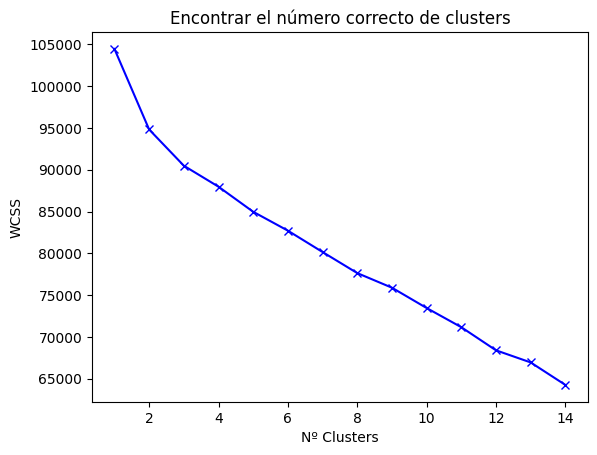

In [53]:
scores = []

range_values = range(1, 15)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(sales_df_scaled)
  scores.append(kmeans.inertia_) # la inercia es la suma de los cuadrados de las distancias de las observaciones al centro del cluster más cercano

plt.plot(range_values, scores, 'bx-')
plt.title('Encontrar el número correcto de clusters')
plt.xlabel('Nº Clusters')
plt.ylabel('WCSS')
plt.show()

# Detalles de Kmeans en Sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# A partir de esto podemos observar que, el 5º grupo parece estar formando el codo de la curva.
# Tengamos en cuenta que la curva cambiará cada vez que ejecutemos la celda

# TAREA #7: APLICAR EL MÉTODO K-MEANS

In [54]:
# Agrupar los datos usando k-means
kmeans = KMeans(5)
kmeans.fit(sales_df_scaled)
labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [55]:
labels

array([4, 4, 1, ..., 2, 2, 2], dtype=int32)

In [56]:
kmeans.cluster_centers_.shape

(5, 37)

In [57]:
# Echemos un vistazo a los centros de los clústeres
cluster_centers_transformados = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])
cluster_centers_transformados

QUANTITYORDERED PRICEEACH ORDERLINENUMBER     SALES  MONTH_ID   YEAR_ID  \
0       -0.170181  0.120853        0.026106  0.034390  0.344773 -0.627006   
1        0.276540  0.593064       -0.018919  0.477132  0.002617  0.007366   
2       -0.037171  0.009763        0.078809 -0.271913 -0.043991  0.001642   
3        1.254287  0.799894       -0.259817  2.575383 -0.118863  0.160878   
4       -0.455699 -0.775805        0.037777 -0.823645 -0.003740  0.017333   

       MSRP PRODUCTCODE Australia   Austria  ... Classic Cars Motorcycles  \
0  0.115706   -0.151523 -0.264819 -0.140961  ...     0.145864    0.147504   
1  0.419366   -0.265481  0.013306  0.028933  ...     0.148373    0.010558   
2 -0.363043    1.126176 -0.230280 -0.017283  ...    -0.721812   -0.364452   
3  1.445643   -0.890508 -0.078720  0.049437  ...     0.595197    0.003636   
4 -0.593140    0.190314  0.064394 -0.024370  ...    -0.104929    0.052956   

     Planes     Ships    Trains Trucks and Buses Vintage Cars     Large  \
0  0.067603 -0.300637 -0.023001        -0.002404    -0.122466  0.014002   
1 -0.020494 -0.300637 -0.048149         0.095285    -0.014878 -0.242672   
2 -0.348674  3.326275 -0.167454        -0.345470    -0.523371 -0.242672   
3 -0.158212 -0.300637 -0.127064        -0.217573    -0.155059  4.120788   
4  0.112087 -0.300637  0.107356        -0.003188     0.156510 -0.242672   

     Medium     Small  
0  0.007720 -0.014196  
1  1.019676 -0.912100  
2 -0.066000  0.177967  
3 -0.980703 -0.912100  
4 -0.980703  1.096370  

[5 rows x 37 columns]

:# Para entender lo que significan estos números, realicemos una transformación inversa

In [58]:
cluster_centers = scaler.inverse_transform(cluster_centers_transformados )


In [59]:
cluster_centers

array([[ 3.34352941e+01,  8.60962353e+01,  6.57647059e+00,
         3.61722000e+03,  8.35294118e+00,  2.00337647e+03,
         1.05364706e+02,  4.89882353e+01,  1.38777878e-17,
         1.38777878e-17, -1.73472348e-18,  6.93889390e-18,
         1.38777878e-17, -6.93889390e-18,  5.55111512e-17,
         2.42861287e-17, -2.60208521e-18,  6.93889390e-18,
        -1.73472348e-17,  1.00000000e+00, -5.20417043e-18,
        -1.04083409e-17,  0.00000000e+00,  1.38777878e-17,
        -3.46944695e-18,  6.93889390e-18,  0.00000000e+00,
         4.11764706e-01,  1.64705882e-01,  1.29411765e-01,
        -1.38777878e-17,  2.35294118e-02,  1.05882353e-01,
         1.64705882e-01,  5.88235294e-02,  4.94117647e-01,
         4.47058824e-01],
       [ 3.77862348e+01,  9.56210526e+01,  6.38623482e+00,
         4.43254651e+03,  7.10202429e+00,  2.00382024e+03,
         1.17565992e+02,  4.53894737e+01,  6.88259109e-02,
         2.34817814e-02,  9.71659919e-03,  2.10526316e-02,
         2.02429150e-02,  3.31

In [60]:
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [sales_df.columns])
cluster_centers

QUANTITYORDERED  PRICEEACH ORDERLINENUMBER        SALES  MONTH_ID  \
0       33.435294  86.096235        6.576471  3617.220000  8.352941   
1       37.786235  95.621053        6.386235  4432.546510  7.102024   
2       34.730769  83.855470        6.799145  3053.150128  6.931624   
3       47.309211  99.792961        5.368421  8296.556316  6.657895   
4       30.654432  68.010009        6.625783  2037.114163  7.078782   

       YEAR_ID        MSRP PRODUCTCODE     Australia       Austria  ...  \
0  2003.376471  105.364706   48.988235  1.387779e-17  1.387779e-17  ...   
1  2003.820243  117.565992   45.389474  6.882591e-02  2.348178e-02  ...   
2  2003.816239   86.128205   89.337607  8.547009e-03  1.709402e-02  ...   
3  2003.927632  158.802632   25.651316  4.605263e-02  2.631579e-02  ...   
4  2003.827216   76.882722   59.783348  8.146822e-02  1.611459e-02  ...   

   Classic Cars   Motorcycles        Planes         Ships        Trains  \
0  4.117647e-01  1.647059e-01  1.294118e-01 -1.387779e-17  2.352941e-02   
1  4.129555e-01  1.206478e-01  1.020243e-01  1.165734e-15  1.943320e-02   
2  4.996004e-16 -2.220446e-16  1.249001e-16  1.000000e+00 -1.110223e-16   
3  6.250000e-01  1.184211e-01  5.921053e-02 -6.938894e-17  6.578947e-03   
4  2.927484e-01  1.342883e-01  1.432408e-01  1.082467e-15  4.476276e-02   

  Trucks and Buses  Vintage Cars         Large        Medium         Small  
0     1.058824e-01  1.647059e-01  5.882353e-02  4.941176e-01  4.470588e-01  
1     1.360324e-01  2.089069e-01  6.730727e-16  1.000000e+00 -8.326673e-16  
2     1.249001e-16  4.718448e-16 -1.595946e-16  4.572650e-01  5.427350e-01  
3     3.947368e-02  1.513158e-01  1.000000e+00 -6.661338e-16  1.387779e-15  
4     1.056401e-01  2.793196e-01  5.898060e-16 -1.054712e-15  1.000000e+00  

[5 rows x 37 columns]

In [ ]:

# Clúster 4 (más alto): este grupo representa a los clientes que compran artículos en una gran cantidad centrada en ~ 47, compran artículos en todos los rangos de precios inclinándose hacia artículos de alto precio de ~ 99. También corresponden a las ventas totales más altas alrededor de ~ 8296 y están activas durante todo el año. Son los mayores compradores de productos con un MSRP alto ~ 158.
# Clúster 1: este grupo representa a los clientes que compran artículos en cantidades variables ~ 35, tienden a comprar artículos de alto precio ~ 96. Sus ventas son un poco mejores en promedio ~ 4435, compran productos con el segundo MSRP más alto de ~ 133.
# Clúster 3 (más bajo): este grupo representa a los clientes que compran artículos en cantidades bajas ~ 30. Suelen comprar artículos de bajo precio ~ 68. Sus ventas ~ 2044 son más bajas que las de otros grupos y son extremadamente activos durante la temporada navideña. Compran productos con un MSRP bajo ~ 75.
# Clúster 0: este grupo representa a los clientes que solo están activos durante las vacaciones. compran en menor cantidad ~ 35, pero tienden a comprar artículos de precio promedio alrededor de ~ 86. También corresponden a ventas totales más bajas alrededor de ~ 3673, tienden a comprar artículos con MSRP alrededor de 102.
# Clúster 2: este grupo representa a los clientes que compran artículos en cantidad variable ~ 39, tienden a comprar artículos de precio promedio ~ 94. Sus ventas ~ 4280.

In [61]:
labels.shape # Etiquetas del clúster asociado a cada observación

(2823,)

In [62]:
labels.max()

4

In [63]:
labels.min()

0

In [64]:
y_kmeans = kmeans.fit_predict(sales_df_scaled)
y_kmeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



array([2, 2, 4, ..., 1, 1, 1], dtype=int32)

In [65]:
y_kmeans.shape

(2823,)

In [66]:
sale_df_cluster = pd.concat([sales_df, pd.DataFrame({'cluster':labels})], axis = 1)
sale_df_cluster

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  MONTH_ID  YEAR_ID  \
0                  30      95.70                2  2871.00         2     2003   
1                  34      81.35                5  2765.90         5     2003   
2                  41      94.74                2  3884.34         7     2003   
3                  45      83.26                6  3746.70         8     2003   
4                  49     100.00               14  5205.27        10     2003   
...               ...        ...              ...      ...       ...      ...   
2818               20     100.00               15  2244.40        12     2004   
2819               29     100.00                1  3978.51         1     2005   
2820               43     100.00                4  5417.57         3     2005   
2821               34      62.24                1  2116.16         3     2005   
2822               47      65.52                9  3079.44         5     2005   

      MSRP  PRODUCTCODE  Australia  Austria  ...  Motorcycles  Planes  Ships  \
0       95            0      False    False  ...         True   False  False   
1       95            0      False    False  ...         True   False  False   
2       95            0      False    False  ...         True   False  False   
3       95            0      False    False  ...         True   False  False   
4       95            0      False    False  ...         True   False  False   
...    ...          ...        ...      ...  ...          ...     ...    ...   
2818    54          108      False    False  ...        False   False   True   
2819    54          108      False    False  ...        False   False   True   
2820    54          108      False    False  ...        False   False   True   
2821    54          108      False    False  ...        False   False   True   
2822    54          108      False    False  ...        False   False   True   

      Trains  Trucks and Buses  Vintage Cars  Large  Medium  Small  cluster  
0      False             False         False  False   False   True        4  
1      False             False         False  False   False   True        4  
2      False             False         False  False    True  False        1  
3      False             False         False  False    True  False        1  
4      False             False         False  False    True  False        1  
...      ...               ...           ...    ...     ...    ...      ...  
2818   False             False         False  False   False   True        2  
2819   False             False         False  False    True  False        2  
2820   False             False         False  False    True  False        2  
2821   False             False         False  False   False   True        2  
2822   False             False         False  False    True  False        2  

[2823 rows x 38 columns]

In [67]:
sale_df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 38 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   QUANTITYORDERED   2823 non-null   int64  
 1   PRICEEACH         2823 non-null   float64
 2   ORDERLINENUMBER   2823 non-null   int64  
 3   SALES             2823 non-null   float64
 4   MONTH_ID          2823 non-null   int64  
 5   YEAR_ID           2823 non-null   int64  
 6   MSRP              2823 non-null   int64  
 7   PRODUCTCODE       2823 non-null   int8   
 8   Australia         2823 non-null   bool   
 9   Austria           2823 non-null   bool   
 10  Belgium           2823 non-null   bool   
 11  Canada            2823 non-null   bool   
 12  Denmark           2823 non-null   bool   
 13  Finland           2823 non-null   bool   
 14  France            2823 non-null   bool   
 15  Germany           2823 non-null   bool   
 16  Ireland           2823 non-null   bool   


In [68]:
sales_df['ORDERLINENUMBER'] = sales_df['ORDERLINENUMBER'].apply(lambda x: float(x))


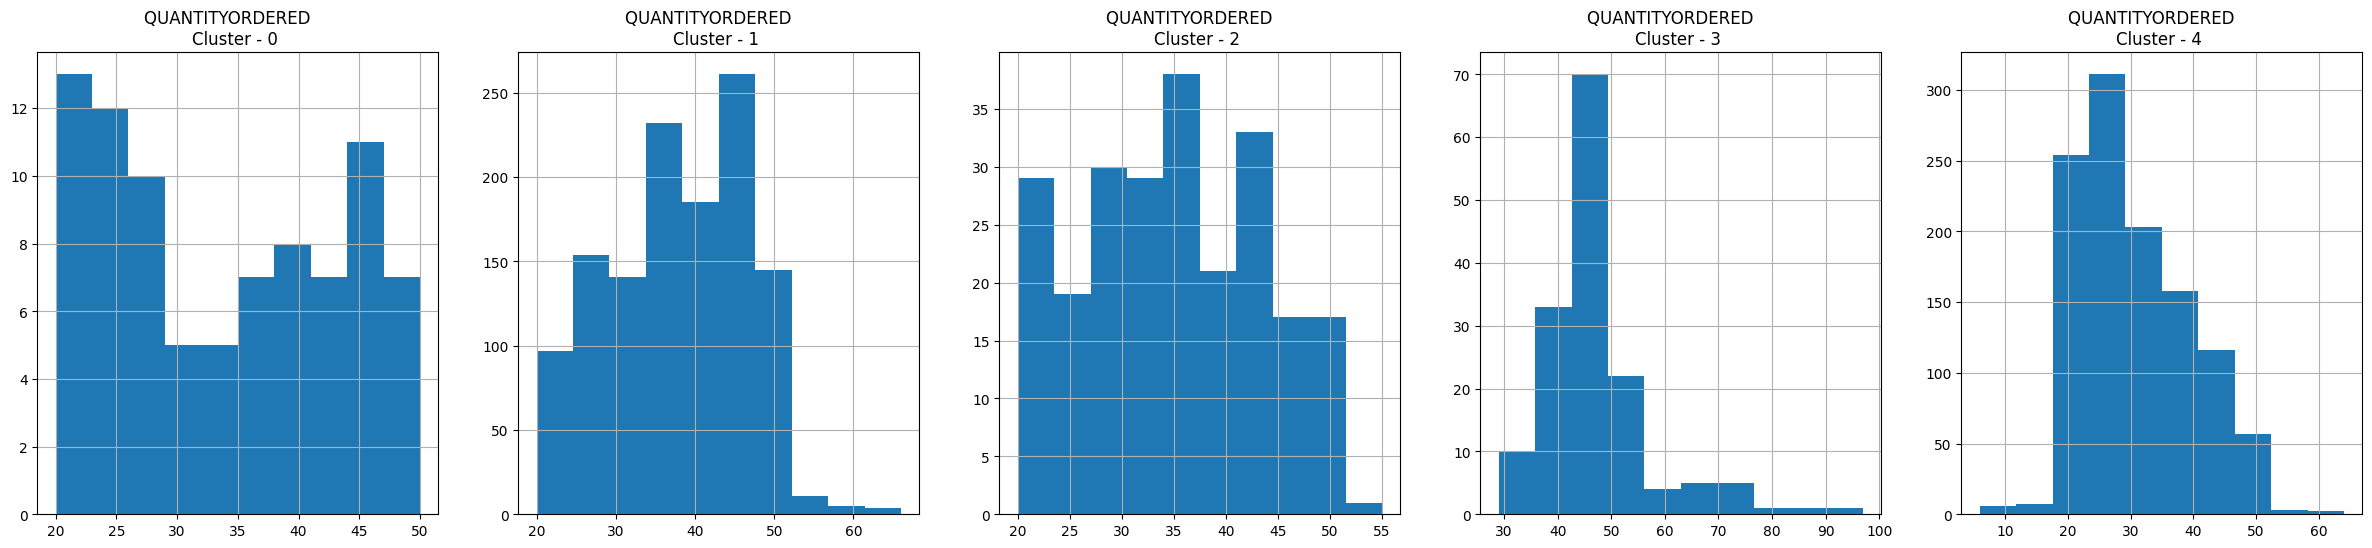

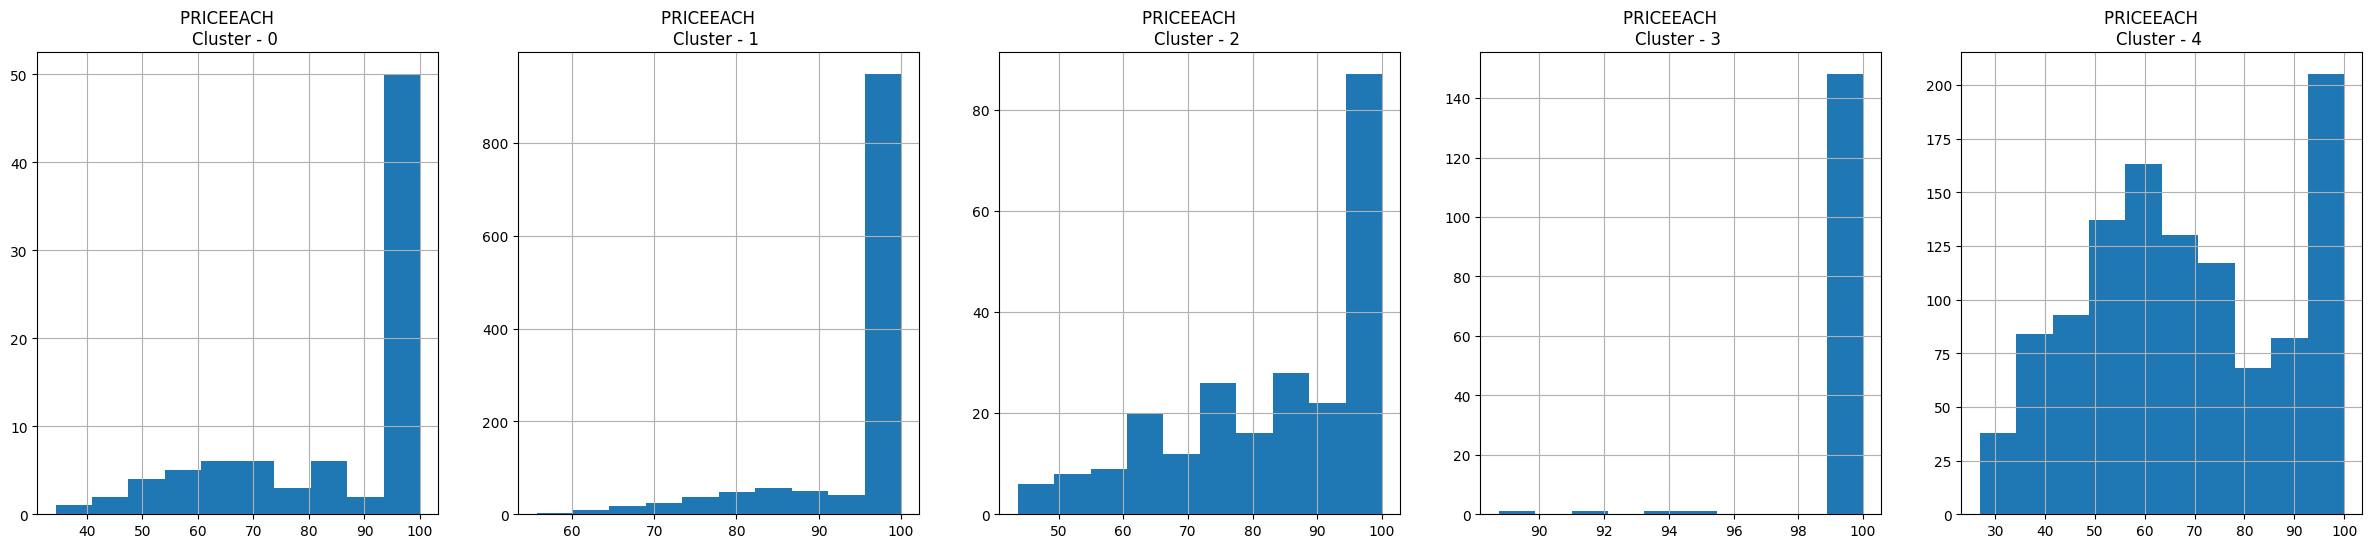

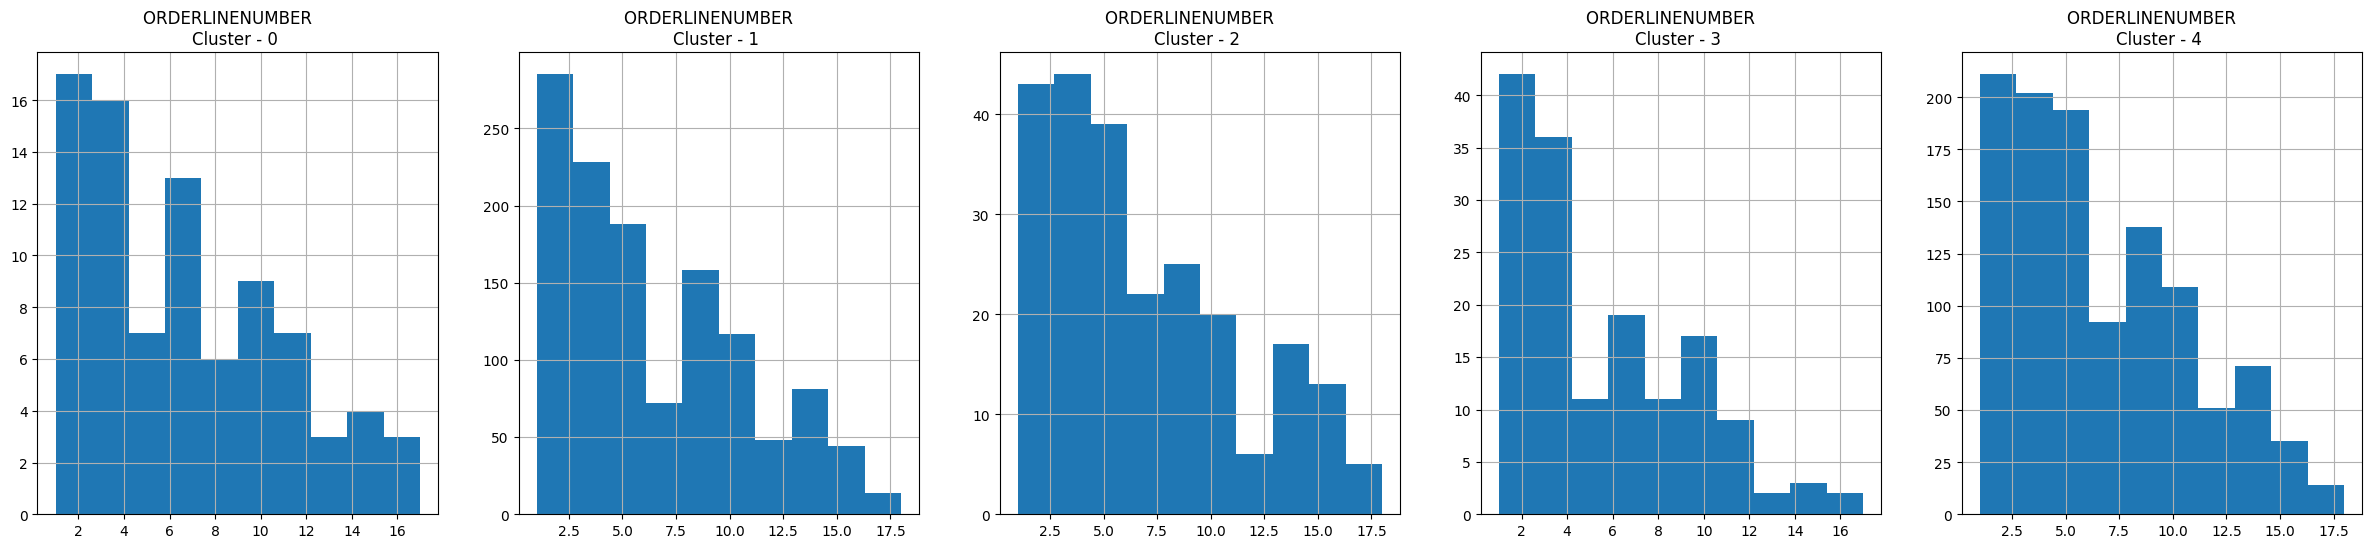

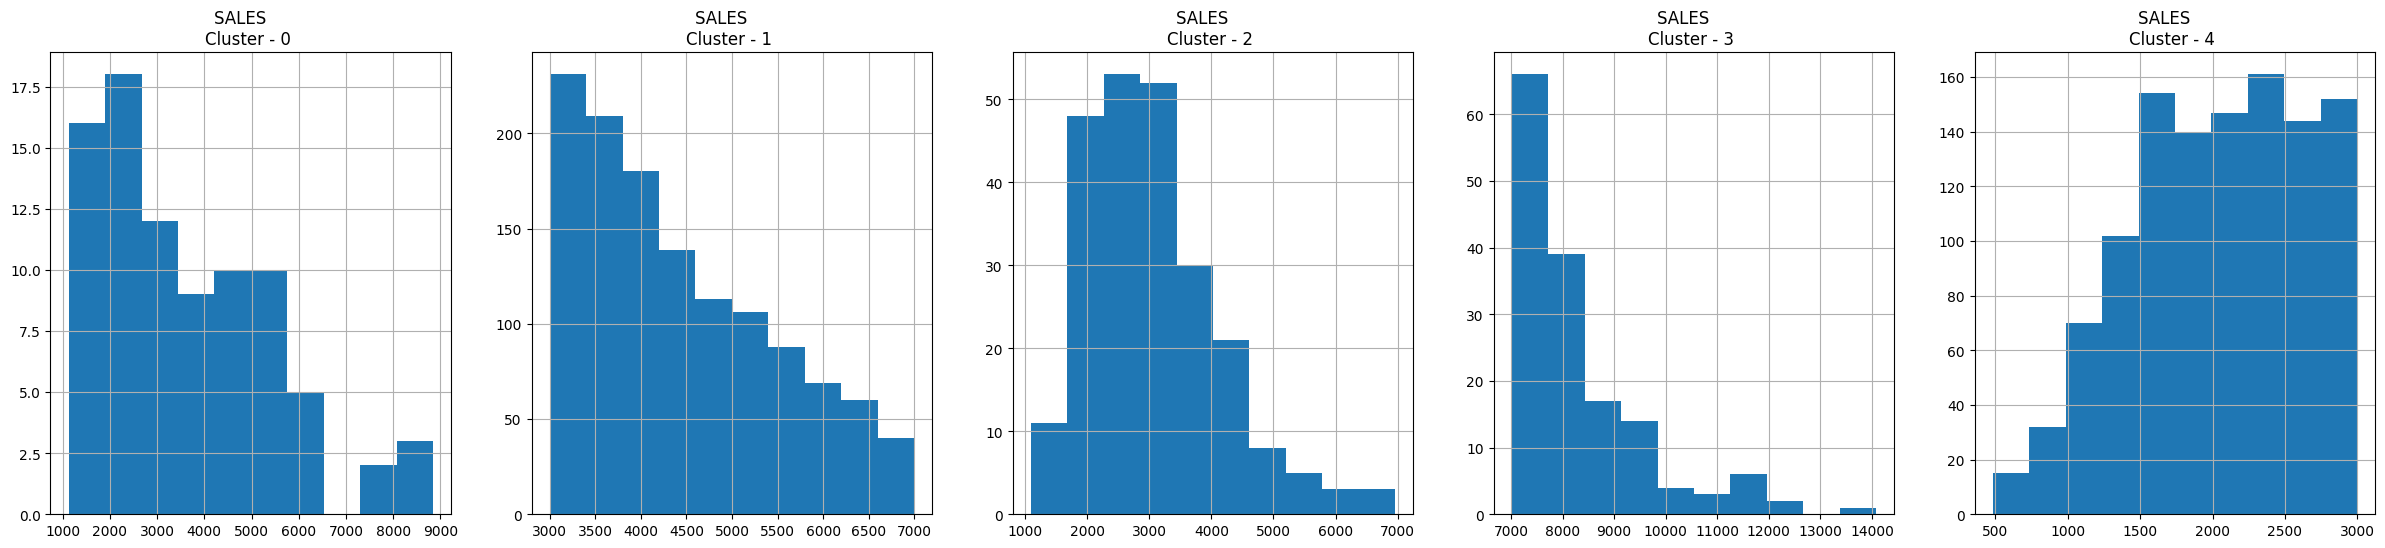

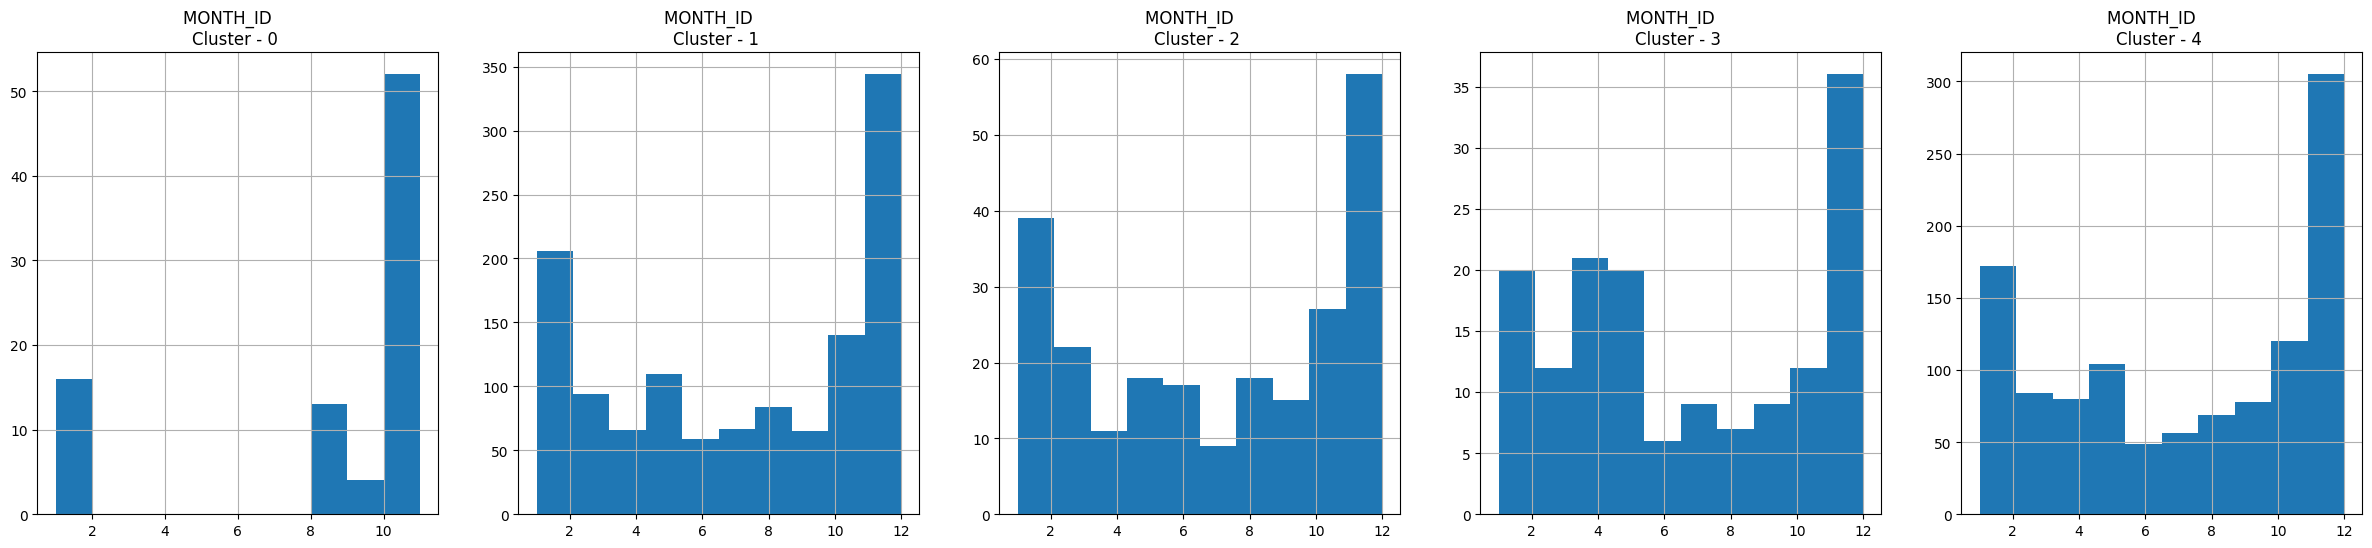

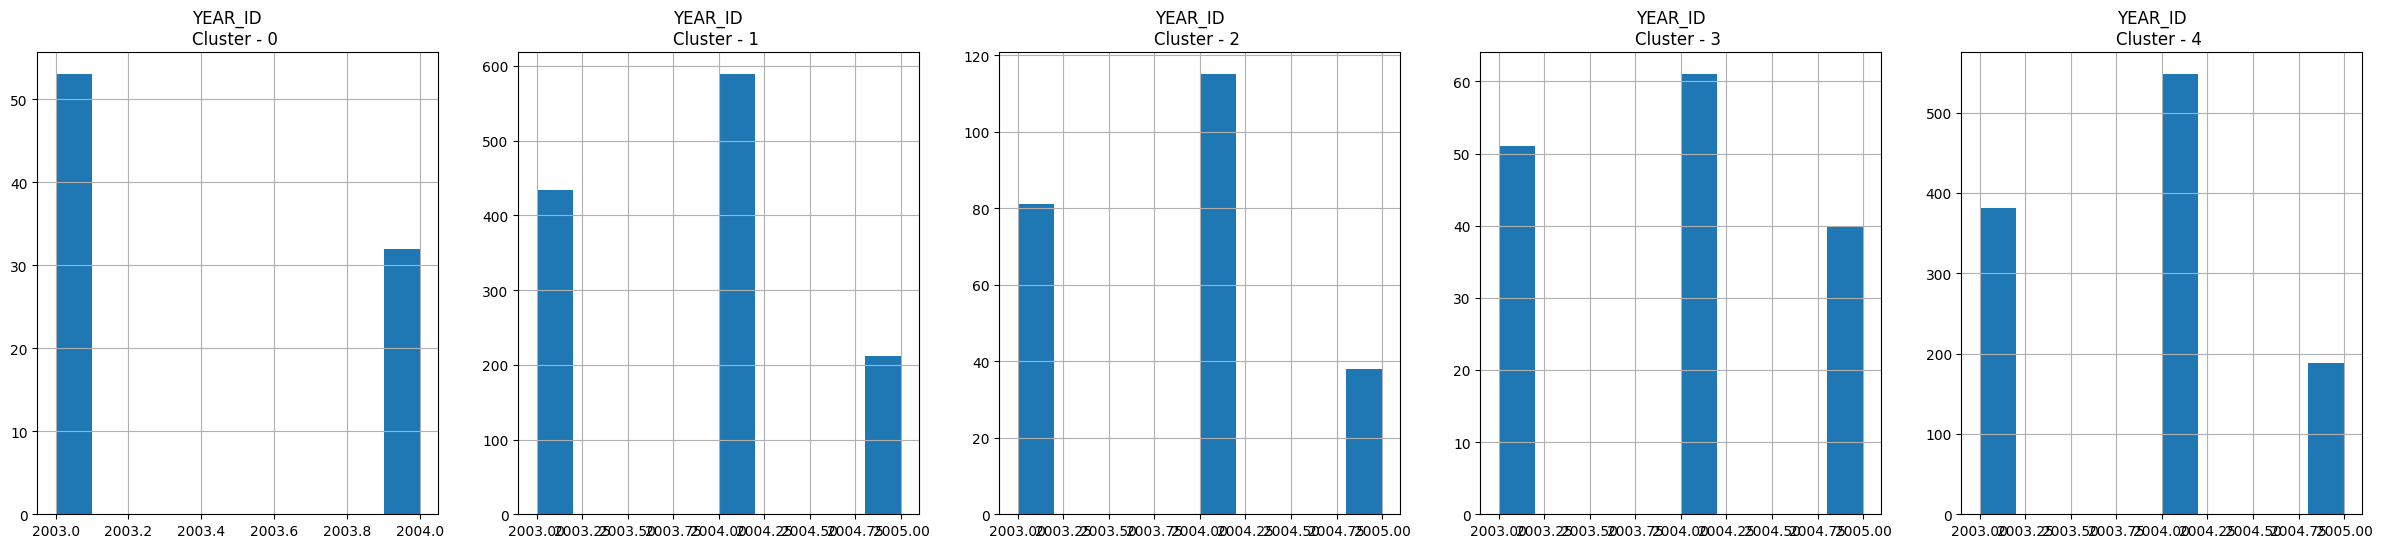

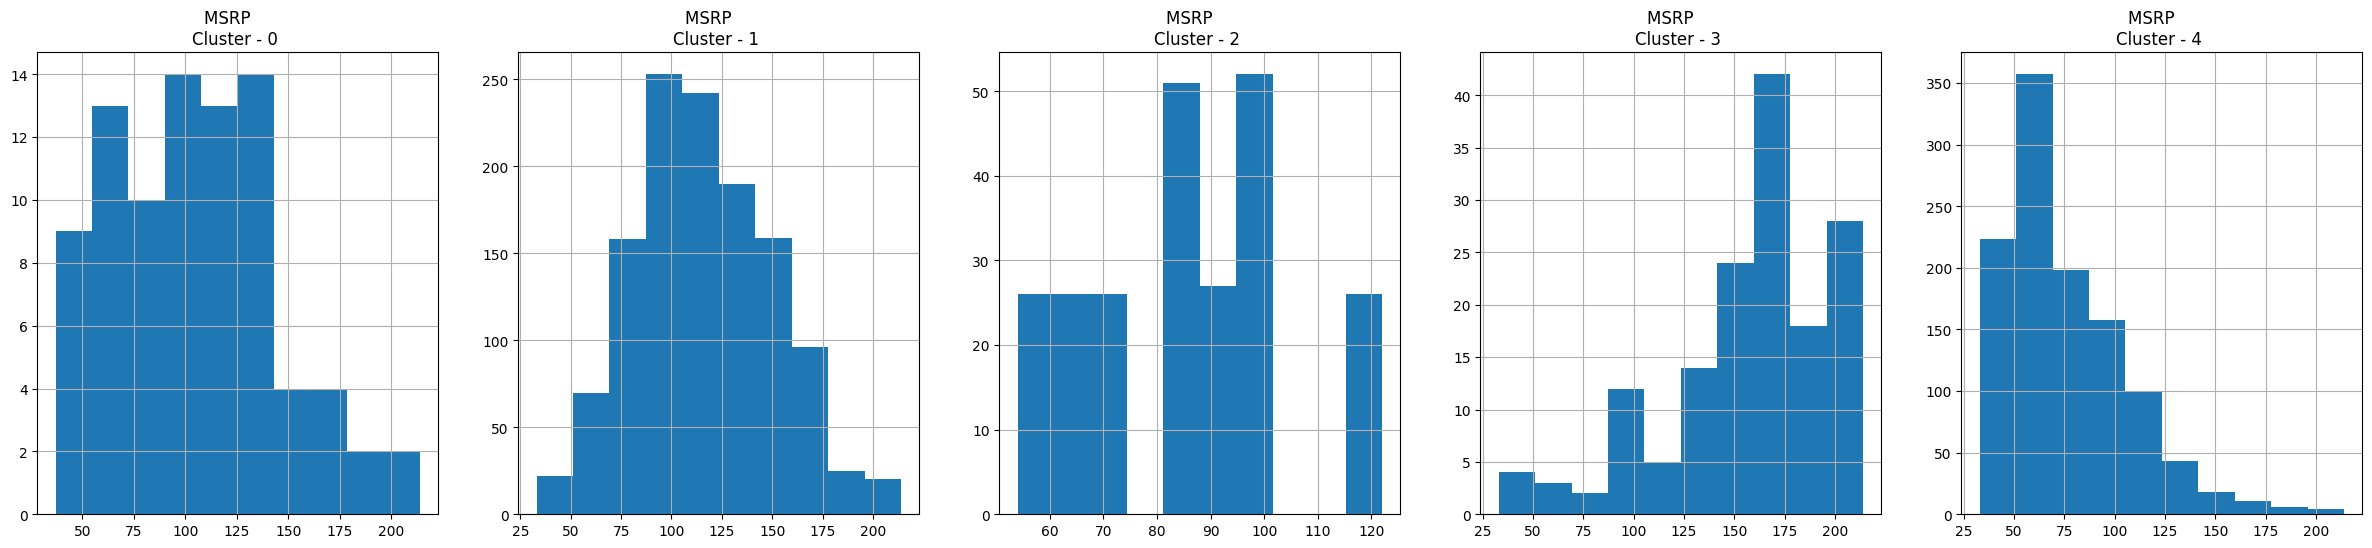

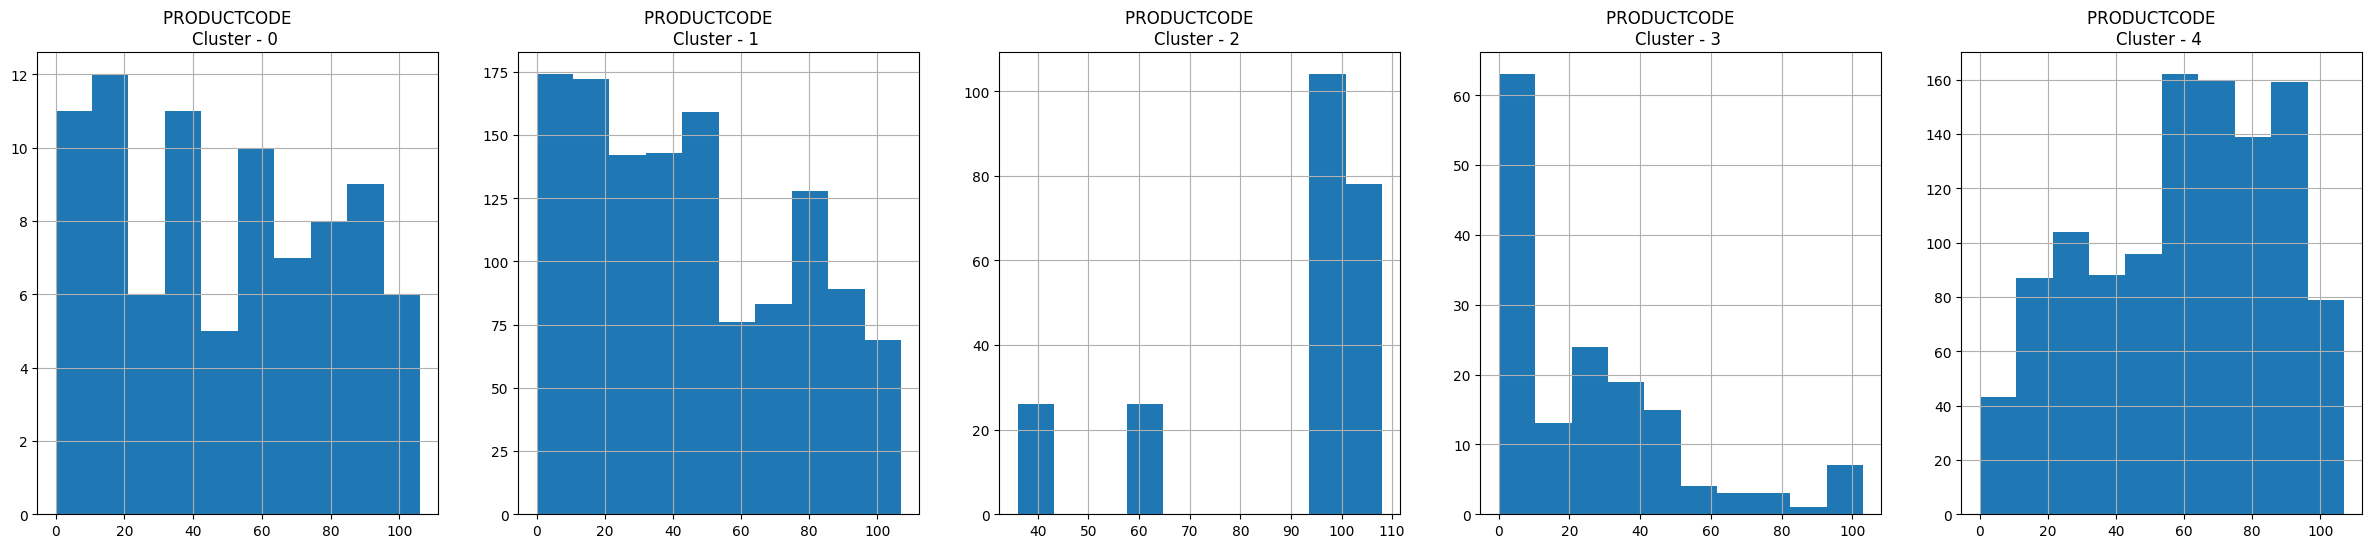

In [69]:
# Representar un histograma para cada característica según el clúster al que pertenece
for i in sales_df.columns[:8]:
  plt.figure(figsize = (30, 6))
  for j in range(5):
    plt.subplot(1, 5, j+1)
    cluster = sale_df_cluster[sale_df_cluster['cluster'] == j]
    cluster[i].hist()
    plt.title('{}    \nCluster - {} '.format(i,j))

  plt.show()

# TAREA #8: APLICAR EL ANÁLISIS DE COMPONENTES PRINCIPALES Y VISUALIZAR LOS RESULTADOS

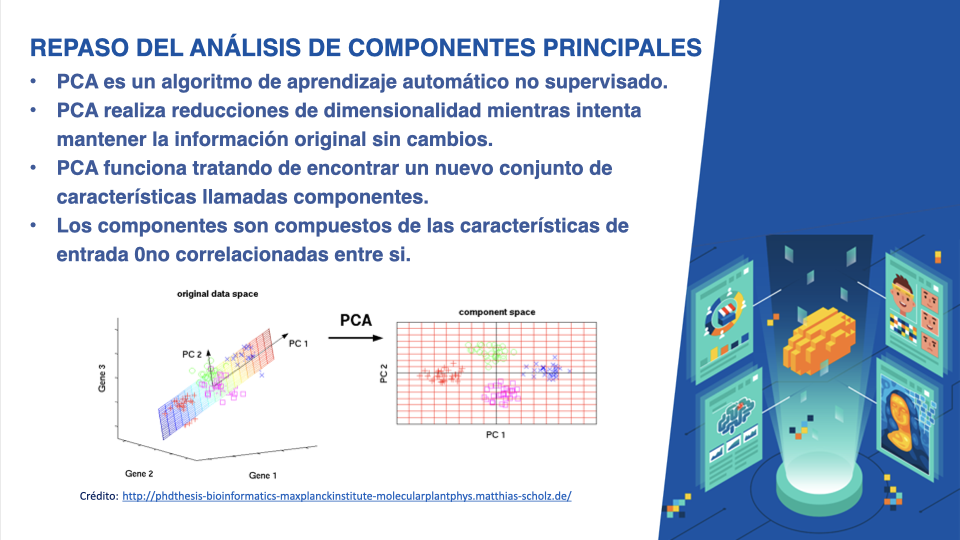

In [70]:
pca = PCA(n_components = 3)
principal_comp = pca.fit_transform(sales_df_scaled)
principal_comp

array([[-0.48633333, -1.1864942 ,  1.04284313],
       [-0.78461807, -1.02016318,  1.51811498],
       [ 1.43150446,  0.11793276,  0.45504288],
       ...,
       [ 0.38986299,  4.13418215, -0.16826789],
       [-2.78873725,  2.45618975,  1.39471074],
       [-0.7054056 ,  3.36248043, -0.53081452]])

In [71]:
pca_df = pd.DataFrame(data = principal_comp, columns = ['pca1', 'pca2', 'pca3'])
pca_df.head()

pca1      pca2      pca3
0 -0.486333 -1.186494  1.042843
1 -0.784618 -1.020163  1.518115
2  1.431504  0.117933  0.455043
3  1.288409 -0.228994 -0.388111
4  1.976008 -0.147079 -0.813430

In [72]:
pca_df.shape

(2823, 3)

In [73]:
# Concatenar las etiquetas de los clústeres al dataframe
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
pca_df

pca1      pca2      pca3  cluster
0    -0.486333 -1.186494  1.042843        4
1    -0.784618 -1.020163  1.518115        4
2     1.431504  0.117933  0.455043        1
3     1.288409 -0.228994 -0.388111        1
4     1.976008 -0.147079 -0.813430        1
...        ...       ...       ...      ...
2818 -2.450325  1.132131 -1.666098        2
2819 -0.158155  3.773734  0.372428        2
2820  0.389863  4.134182 -0.168268        2
2821 -2.788737  2.456190  1.394711        2
2822 -0.705406  3.362480 -0.530815        2

[2823 rows x 4 columns]

In [74]:
# Visualizar los clústeres con 3D-Scatterplot
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3',
              color = 'cluster', symbol = 'cluster', size_max = 18, opacity = 0.7)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))

MINI RETO #8:
- Cambia el número de componentes a 2, modifica el código y vuelve a ejecutar el modelo
- Visualiza los clústeres usando gráficos 2D

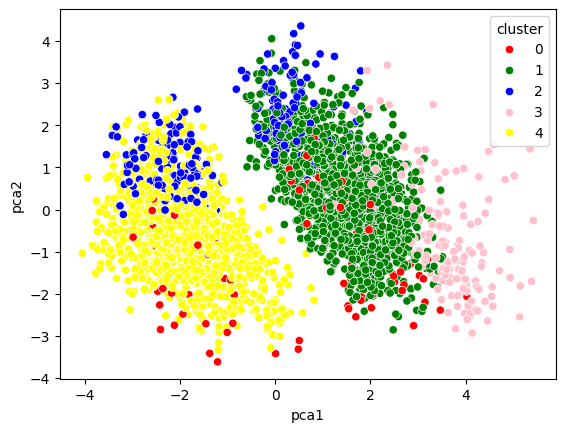

In [75]:
pca = PCA(n_components = 2)
principal_comp = pca.fit_transform(sales_df_scaled)

pca_df = pd.DataFrame(data = principal_comp, columns = ['pca1', 'pca2'])
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)

ax = sns.scatterplot(x = "pca1", y = "pca2", hue = "cluster", data = pca_df, palette = ["red", "green", "blue", "pink", "yellow"])
plt.show()

# TAREA #9: ENTENDER LA TEORÍA Y LA INTUICIÓN DETRÁS DE AUTOENCODERS

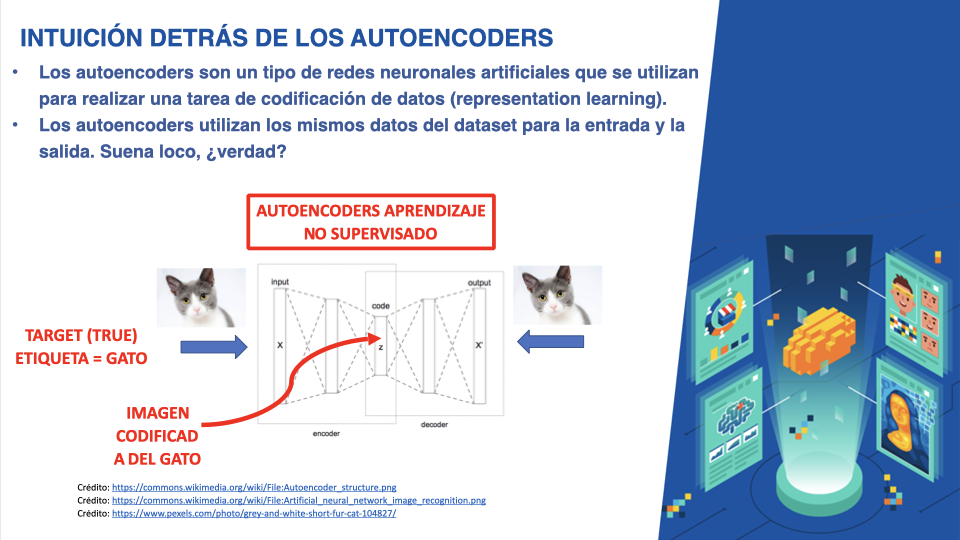

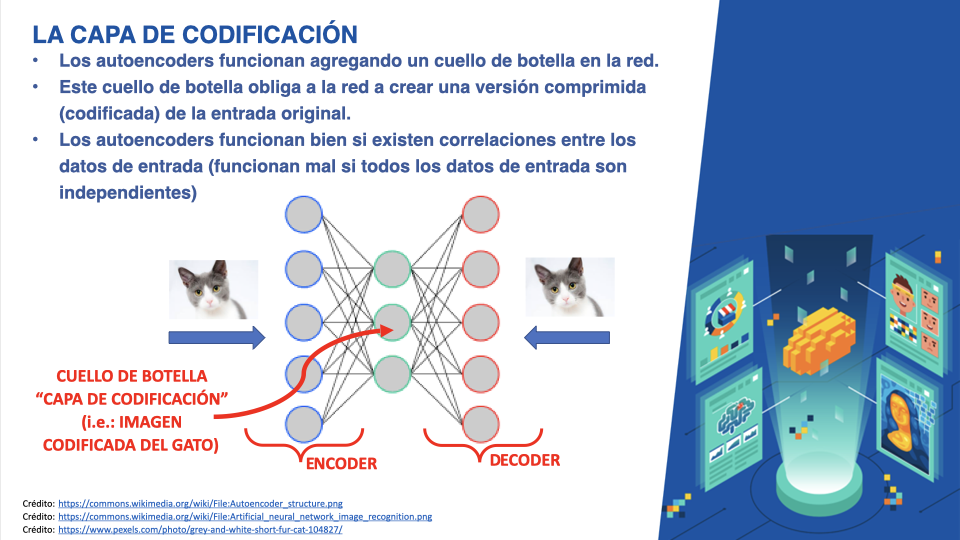

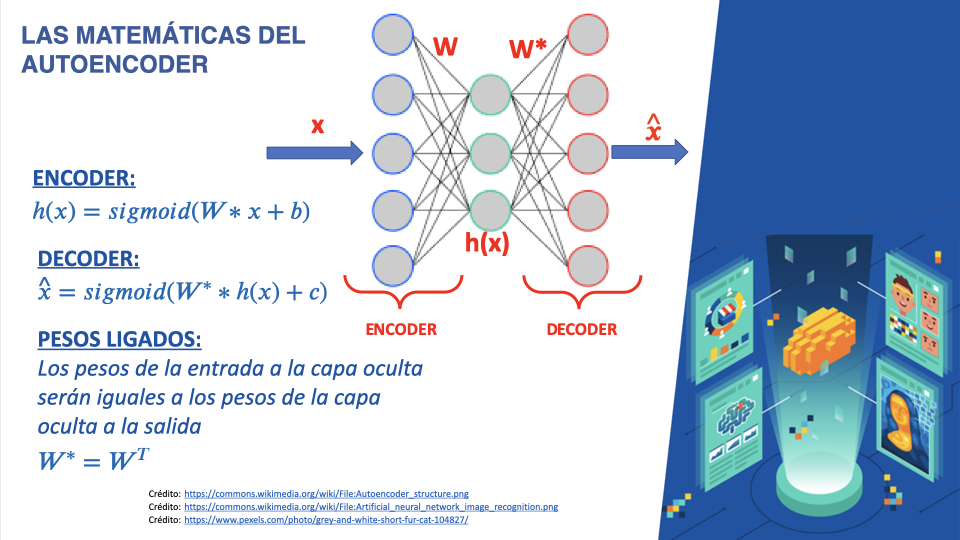

# TAREA #10: APLICAR AUTOENCODERS (REALIZAR REDUCCIÓN DE DIMENSIONALIDAD USANDO AUTOENCODERS)

In [76]:
sales_df.shape

(2823, 37)

In [77]:
# from keras.optimizers import SGD

# Glorot Uniform initializer: https://keras.rstudio.com/reference/initializer_glorot_uniform.html
# Sobre estas consideraciones, proponemos un nuevo esquema de inicialización que trae sustancialmente más rápido
# convergencia.

# Red neuronal densa que partirá desde el input, el cual tiene obs de 37 var, q irá pasando x capas densas,
# de 37 a 50 neuronas, luego a 500, y finalmente acabaré en 2000
# Utilizaremos como función de act el rectificador lineal unitario,
# con un inicializador glorot_uniform a la hora de inicializar estos pesos aleatoriamente
# el gloro_uniform nos da una mejora para que la convergencia sea más rápida sobre todo en el caso de los autoencoders.

# Ayuda a que los pesos sean cercanos a 0
# de una forma + posit que lo q haría una dist Uniforme o una dist normal

# se llegará a un pto en que lleguemos a capa densidad 2k, en la cual se guardará en una va encoded que sólo tiene 8 neuronas.
# ->Abré repartido las var en tanta densidad en la fase de codificacion para al final quedarme con una resumen de 8 variables
# que es menor a ls 37 var de partidas, sin perder info
# es decir si va a poder re construir llegando a una densidad de 37 q se almacena en una var decoded

# Fijarse dos cosas la capa del centro la he llamo encoded para ser capaz de quedarme con ella y la capa de salida la he llamado decoded
# la cual devuelve los mismos valores que tenía en la capa de entrada
input_df = Input(shape = (37,))
x = Dense(50, activation = 'relu')(input_df)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
encoded = Dense(8, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
decoded = Dense(37, kernel_initializer = 'glorot_uniform')(x)

# autoencoder -> le estoy pidiendo que me genere un modelo pasando desde el input_df(37 ) hasta decoded, osea todas las capas de la red
autoencoder = Model(input_df, decoded)

# encoder - utilizado para reducir la dimensión - En este caso reducir las variables que utilizaremos en la segmentación (cluster)
encoder = Model(input_df, encoded)

# Utilizaremos el optimizador adam -El gradiente descendente estocático, y como función de pérdida el error cuadrático promedio
# El autoencoder busca que los 37 var de predicciones sean las mismas que las 37 var de predicciones de salida.
# en el intermedio abrá pasado x una capa de 8 neuronas, que se capturan en el model de encoder.
# Pasar el resultado de ese encoder a un kmeans
autoencoder.compile(optimizer = 'adam', loss='mean_squared_error')

In [78]:
# Se entrena con un fit, en este caso vamos a entrenar x lotes de 128, bastantes epochs (va a pasar muchas veces x esos datos)
# verbose = 3 para que en lugar que me muestre la información detallada sólo me arroje el epoch actual y el total
autoencoder.fit(sales_df_scaled, sales_df_scaled, batch_size = 128, epochs = 500, verbose = 3)

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

In [ ]:
autoencoder.save_weights('autoencoder_1.h5')

In [ ]:
# Con el encoder sólo sacaremos valores para 8 variables, que fueron las 8 neuronas donde guardamos el resumen o compresión de las variables
# pero tener en cuenta que las predicciones se alimentan con las 37 características o variables del df sales escalado
pred = encoder.predict(sales_df_scaled)

89/89 [==============================] - 1s 8ms/step


In [ ]:
sales_df_scaled.shape

(2823, 37)

In [ ]:
pred.shape


(2823, 8)

In [ ]:
pred

array([[0.       , 0.       , 4.4354596, ..., 0.       , 0.       ,
        2.036153 ],
       [0.       , 0.       , 5.756067 , ..., 0.       , 0.       ,
        4.9123693],
       [0.       , 0.       , 3.8531327, ..., 0.       , 0.       ,
        1.6385049],
       ...,
       [0.       , 6.845576 , 1.3113985, ..., 0.       , 0.       ,
        4.728535 ],
       [0.       , 4.891707 , 1.1606504, ..., 0.       , 0.       ,
        5.0281706],
       [0.       , 4.994001 , 0.5637803, ..., 0.       , 0.       ,
        2.623534 ]], dtype=float32)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

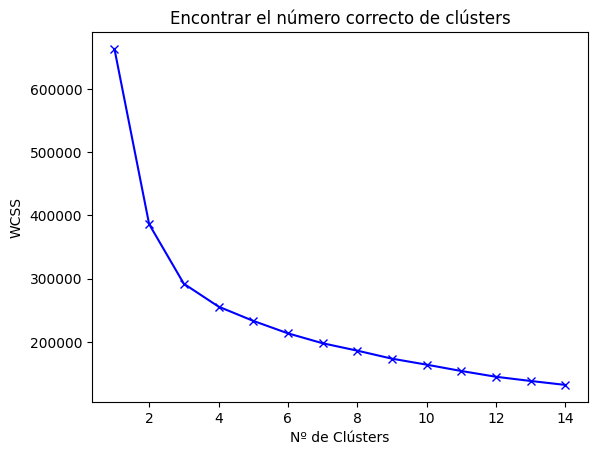

In [ ]:
scores = []
# Rango o número de clusters que se generarán para evaluar cul es más eficiente utilizando el método del codo
range_values = range(1, 15)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  # con fit entrenamos el modelo, al cual se alimenta de los valores de pred que tienen 8 características
  kmeans.fit(pred)
  # Inertia nos devuelve la suma de los cuadrados de las distancias intraclusters WCSS
  scores.append(kmeans.inertia_)

plt.plot(range_values, scores, 'bx-')
plt.title('Encontrar el número correcto de clústers')
plt.xlabel('Nº de Clústers')
plt.ylabel('WCSS')
plt.show()

In [ ]:
kmeans = KMeans(3)
#hacemos un fit de los valores comprimidos por el autoencoder (valores pred 8 variables, las filas son las ventas de los datasets originales)
kmeans.fit(pred)
labels = kmeans.labels_
# ahora predecimos con el clustering original
y_kmeans = kmeans.fit_predict(sales_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
y_kmeans

array([1, 1, 0, ..., 0, 1, 0], dtype=int32)

In [ ]:
df_cluster_dr = pd.concat([sales_df, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster_dr.head()

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  MONTH_ID  YEAR_ID  \
0               30      95.70              2.0  2871.00         2     2003   
1               34      81.35              5.0  2765.90         5     2003   
2               41      94.74              2.0  3884.34         7     2003   
3               45      83.26              6.0  3746.70         8     2003   
4               49     100.00             14.0  5205.27        10     2003   

   MSRP  PRODUCTCODE  Australia  Austria  ...  Motorcycles  Planes  Ships  \
0    95            0      False    False  ...         True   False  False   
1    95            0      False    False  ...         True   False  False   
2    95            0      False    False  ...         True   False  False   
3    95            0      False    False  ...         True   False  False   
4    95            0      False    False  ...         True   False  False   

   Trains  Trucks and Buses  Vintage Cars  Large  Medium  Small  cluster  
0   False             False         False  False   False   True        1  
1   False             False         False  False   False   True        1  
2   False             False         False  False    True  False        1  
3   False             False         False  False    True  False        1  
4   False             False         False  False    True  False        1  

[5 rows x 38 columns]

In [ ]:
df_cluster_dr.tail()

QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  MONTH_ID  YEAR_ID  \
2818               20     100.00             15.0  2244.40        12     2004   
2819               29     100.00              1.0  3978.51         1     2005   
2820               43     100.00              4.0  5417.57         3     2005   
2821               34      62.24              1.0  2116.16         3     2005   
2822               47      65.52              9.0  3079.44         5     2005   

      MSRP  PRODUCTCODE  Australia  Austria  ...  Motorcycles  Planes  Ships  \
2818    54          108      False    False  ...        False   False   True   
2819    54          108      False    False  ...        False   False   True   
2820    54          108      False    False  ...        False   False   True   
2821    54          108      False    False  ...        False   False   True   
2822    54          108      False    False  ...        False   False   True   

      Trains  Trucks and Buses  Vintage Cars  Large  Medium  Small  cluster  
2818   False             False         False  False   False   True        2  
2819   False             False         False  False    True  False        0  
2820   False             False         False  False    True  False        1  
2821   False             False         False  False   False   True        1  
2822   False             False         False  False    True  False        1  

[5 rows x 38 columns]

In [ ]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])
cluster_centers

QUANTITYORDERED PRICEEACH ORDERLINENUMBER     SALES  MONTH_ID   YEAR_ID  \
0        0.293073  0.580208       -0.010805  0.458608  0.003368 -0.012482   
1       -0.468912 -0.724370        0.043454 -0.810304  0.007142 -0.003285   
2        1.245428  0.800220       -0.259579  2.573861 -0.088008  0.136857   

       MSRP PRODUCTCODE Australia   Austria  ... Classic Cars Motorcycles  \
0  0.376634   -0.165542 -0.013717  0.010642  ...     0.085141   -0.014094   
1 -0.581757    0.285478  0.025174 -0.016801  ...    -0.162957    0.013781   
2  1.430265   -0.871802 -0.084647  0.043374  ...     0.580097    0.011712   

     Planes     Ships    Trains Trucks and Buses Vintage Cars     Large  \
0 -0.048853 -0.020232 -0.052121         0.064221    -0.064346 -0.242672   
1  0.072858  0.058660  0.071986        -0.044714     0.087993 -0.242672   
2 -0.164278 -0.300637 -0.128350        -0.201008    -0.151285  4.120788   

     Medium    Small  
0  1.019676 -0.91210  
1 -0.980703  1.09637  
2 -0.980703 -0.91210  

[3 rows x 37 columns]

In [ ]:
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [sales_df.columns])
cluster_centers

QUANTITYORDERED  PRICEEACH ORDERLINENUMBER        SALES  MONTH_ID  \
0       37.947254  95.361741        6.420520  4398.433699  7.104769   
1       30.525741  69.047496        6.649766  2061.682800  7.118565   
2       47.222930  99.799554        5.369427  8293.753248  6.770701   

       YEAR_ID        MSRP PRODUCTCODE Australia   Austria  ... Classic Cars  \
0  2003.806358  115.848988   48.545520  0.062139  0.020954  ...     0.382948   
1  2003.812793   77.340094   62.788612  0.071763  0.017161  ...     0.265211   
2  2003.910828  158.184713   26.242038  0.044586  0.025478  ...     0.617834   

  Motorcycles    Planes         Ships    Trains Trucks and Buses Vintage Cars  \
0    0.112717  0.093208  7.731214e-02  0.018786         0.126445     0.188584   
1    0.121685  0.131045  9.906396e-02  0.039002         0.092824     0.251170   
2    0.121019  0.057325 -6.938894e-17  0.006369         0.044586     0.152866   

          Large        Medium         Small  
0  7.424616e-16  1.000000e+00 -3.885781e-16  
1  6.869505e-16 -1.110223e-15  1.000000e+00  
2  1.000000e+00 -7.216450e-16  1.387779e-15  

[3 rows x 37 columns]

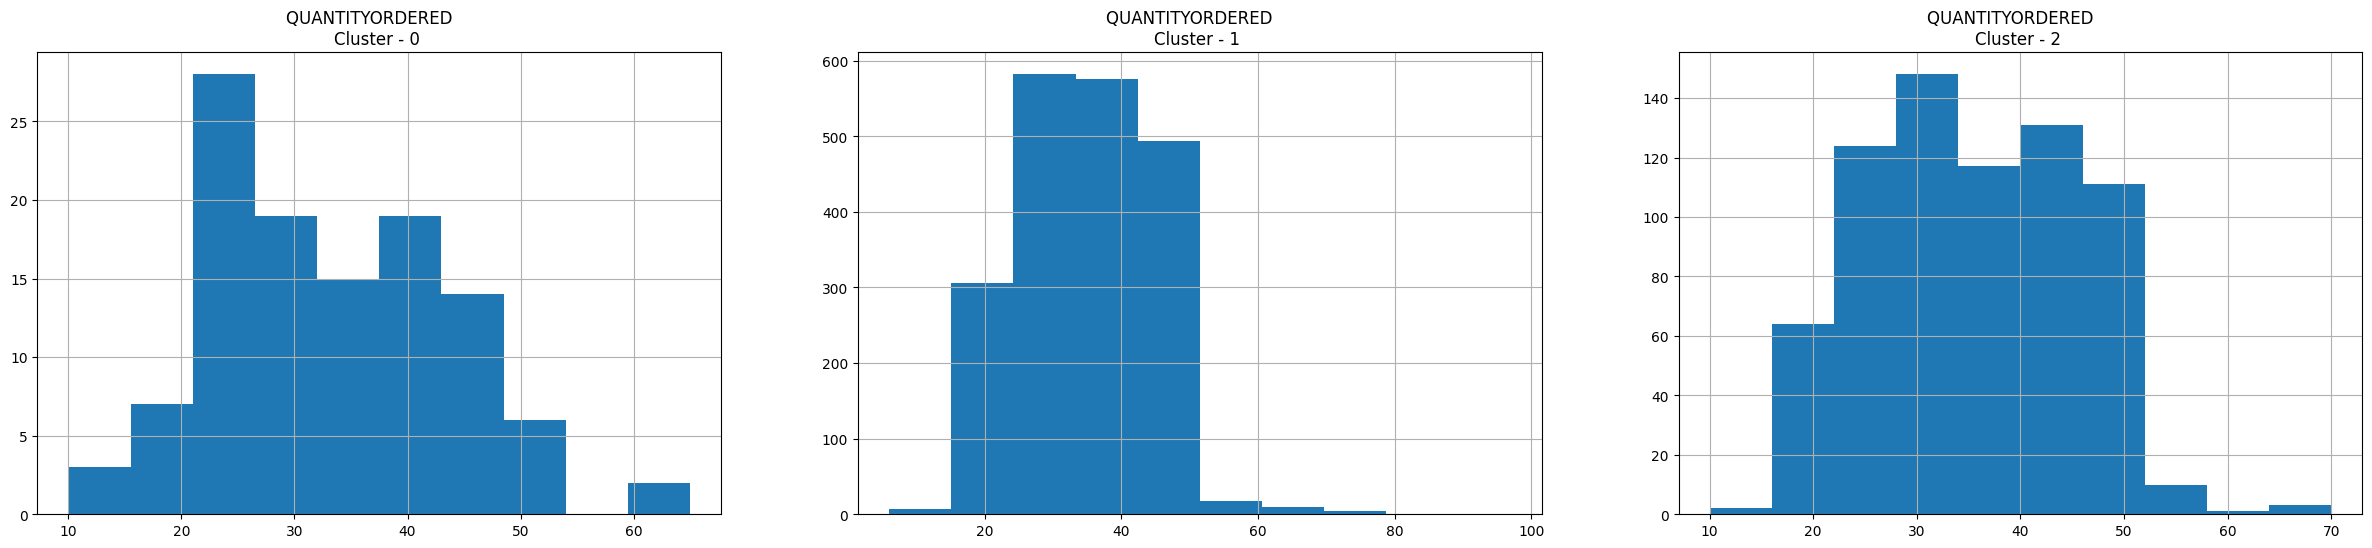

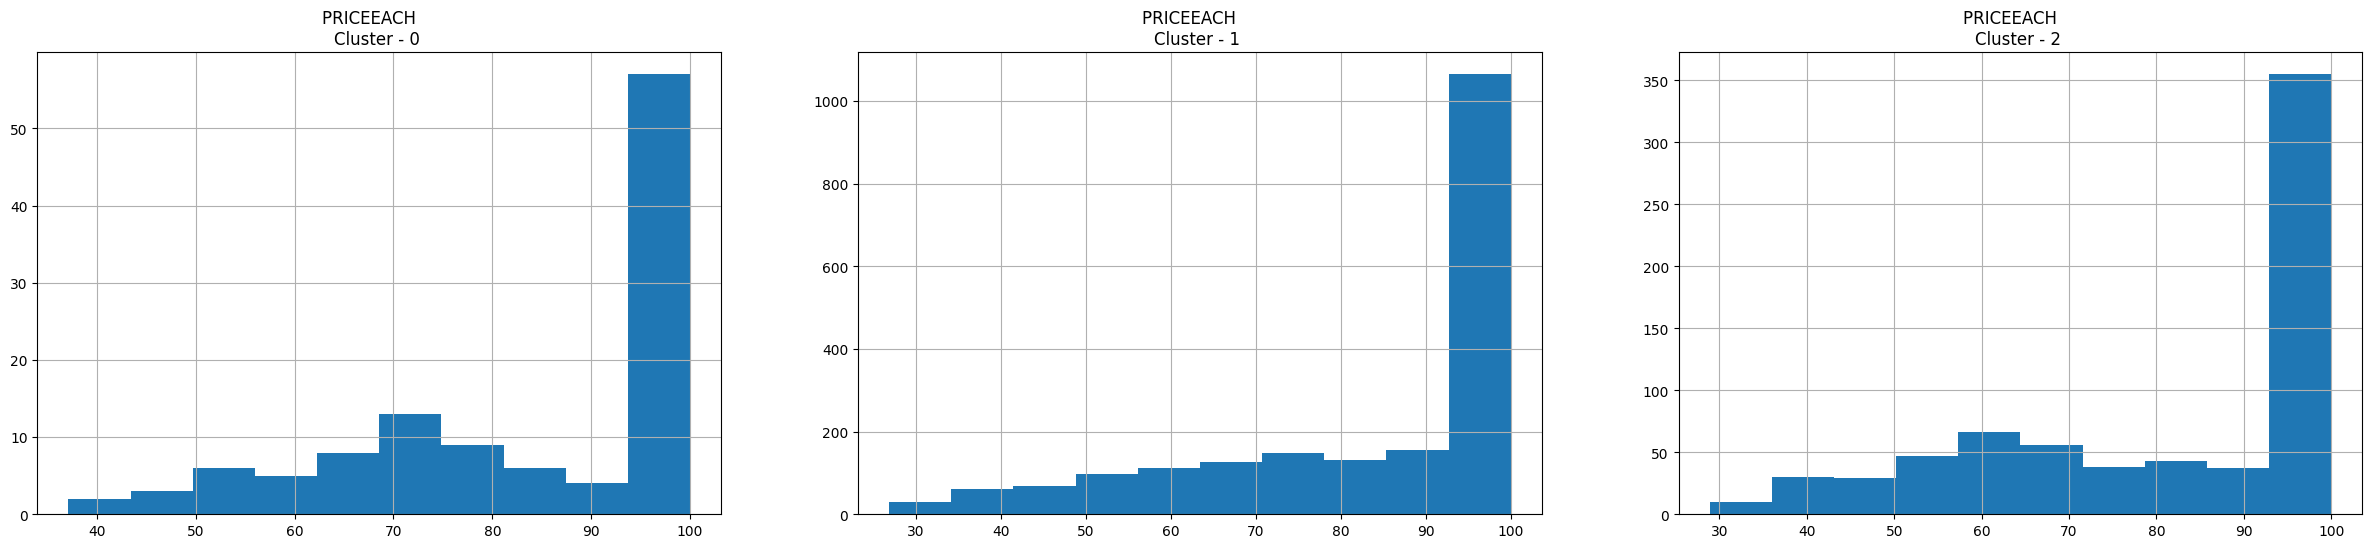

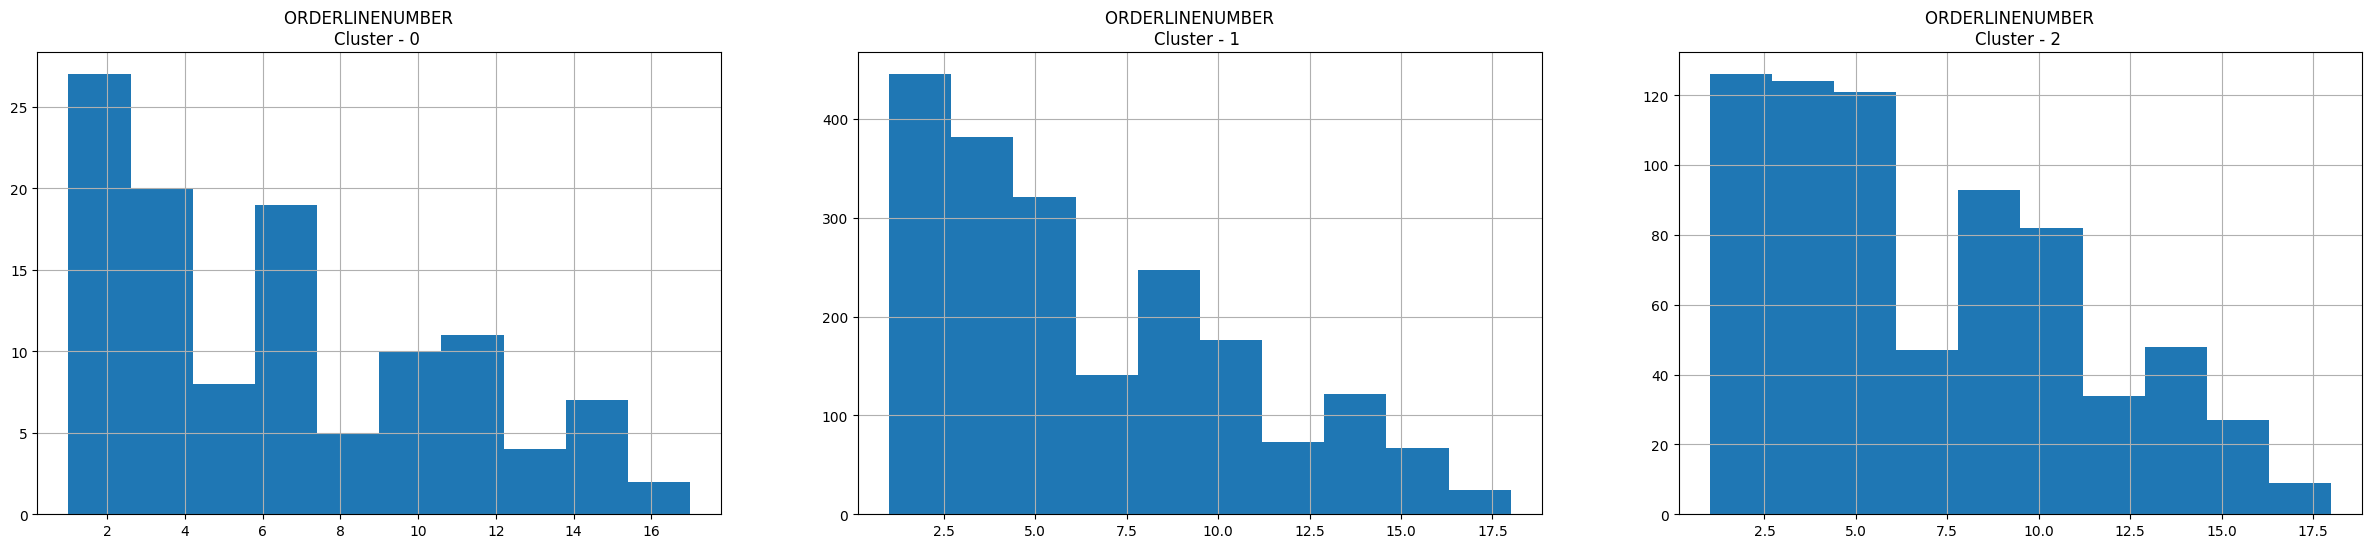

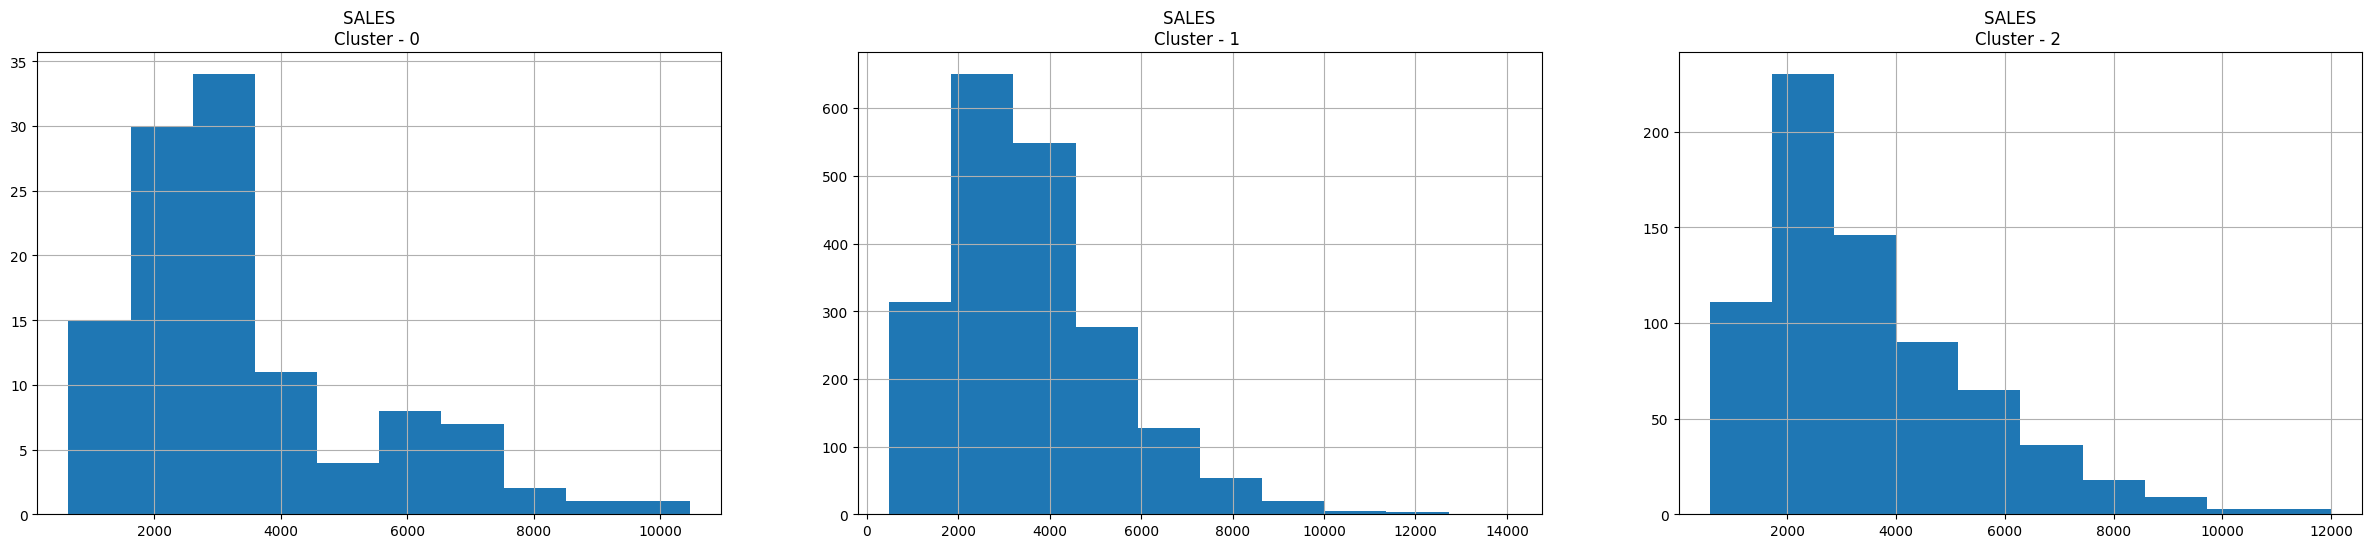

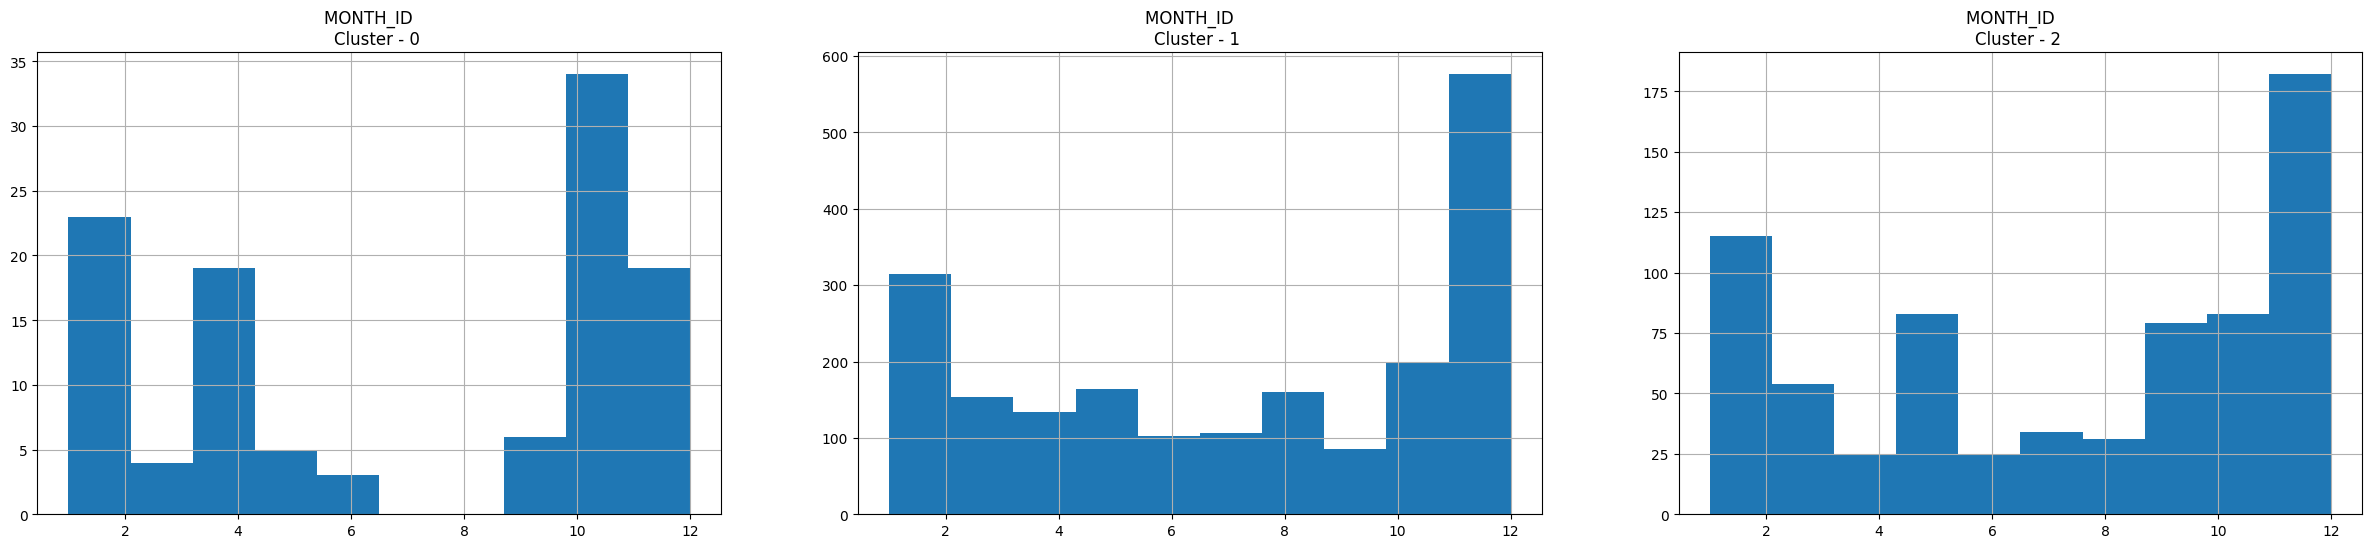

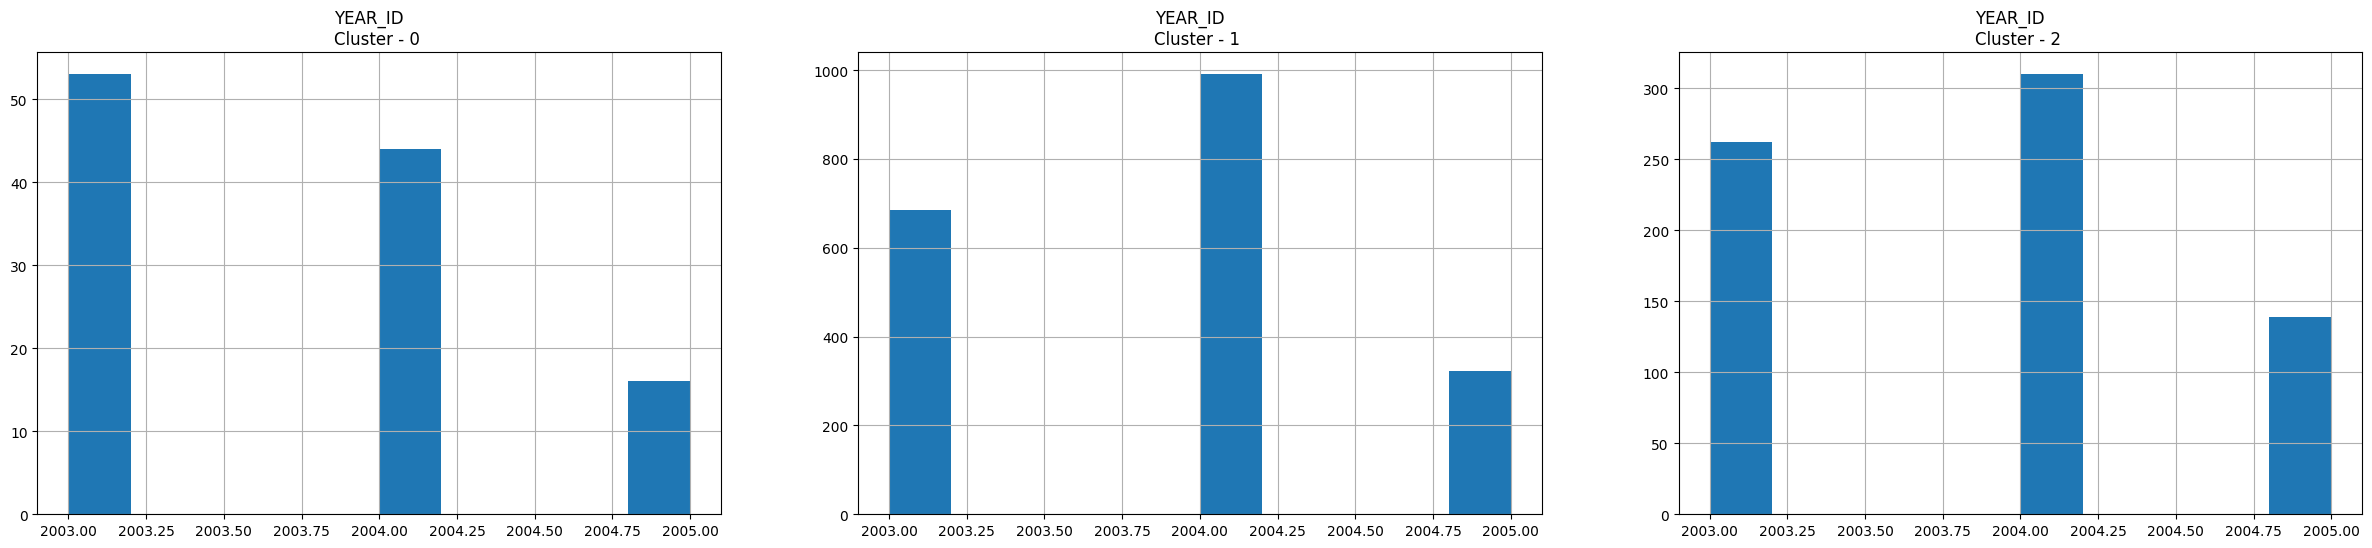

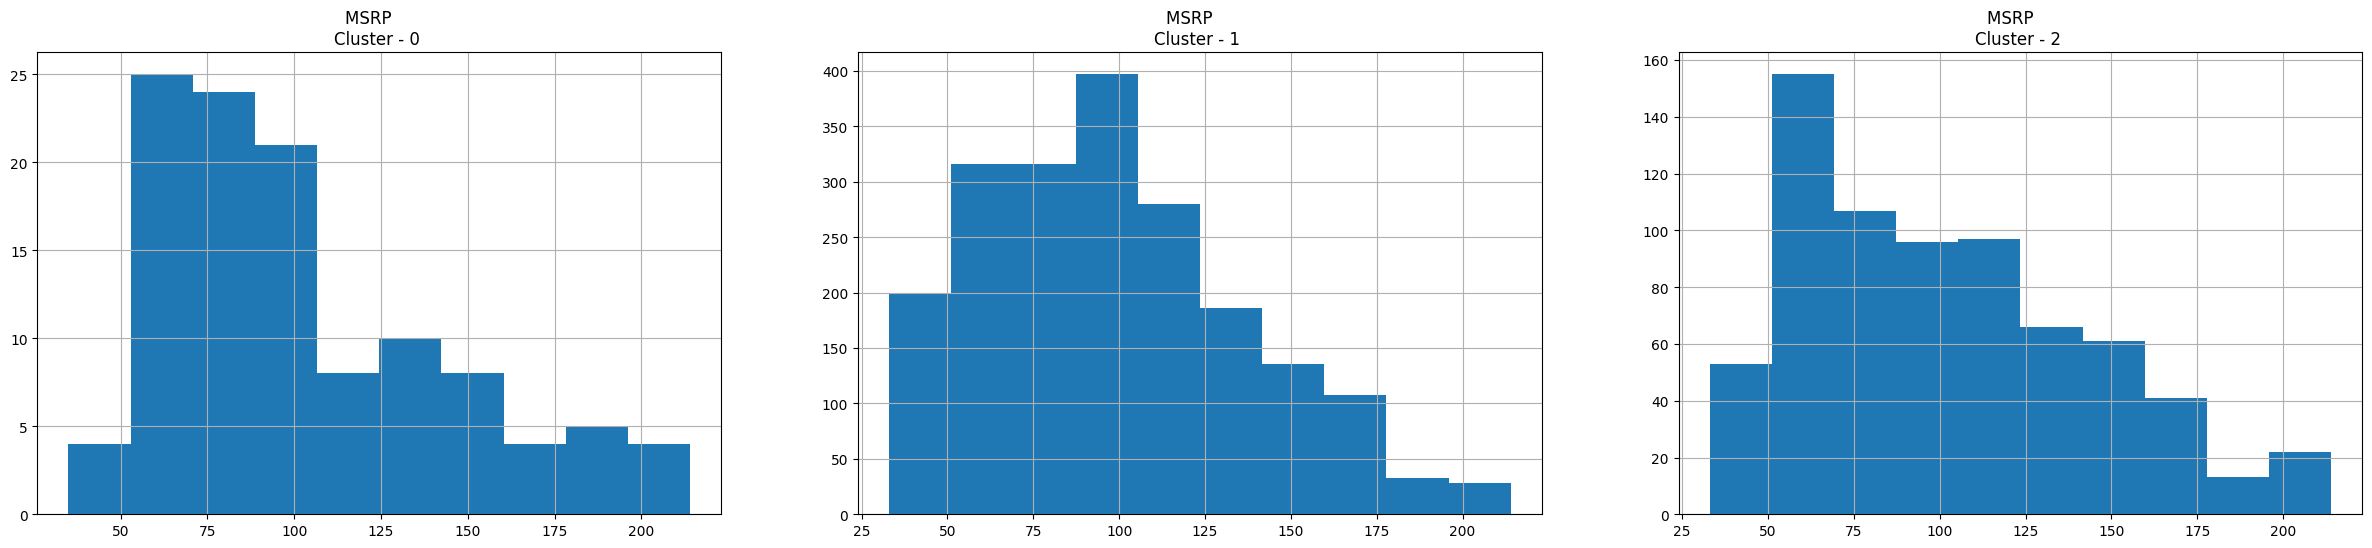

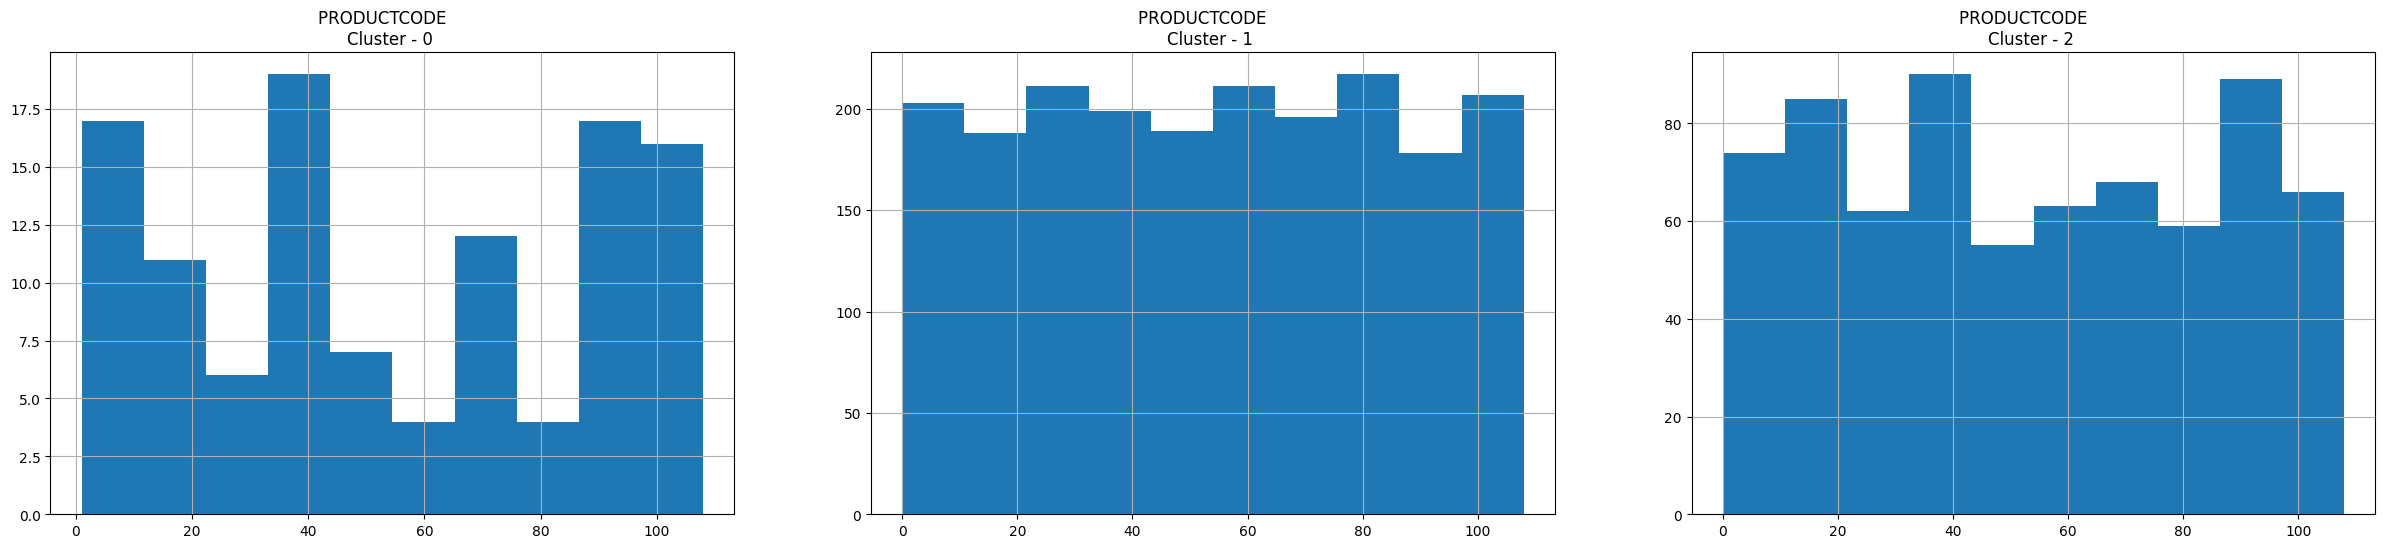

In [ ]:
# plot histogram for each feature based on cluster
for i in sales_df.columns[:8]:
  plt.figure(figsize = (30, 6))
  for j in range(3):
    plt.subplot(1, 3, j+1)
    cluster = df_cluster_dr[df_cluster_dr['cluster'] == j]
    cluster[i].hist()
    plt.title('{}    \nCluster - {} '.format(i,j))

  plt.show()

In [ ]:
# Reducir los datos originales a 3 dimensiones usando ACP para visualizar los clústeres
pca = PCA(n_components = 3)
prin_comp = pca.fit_transform(sales_df_scaled)
pca_df = pd.DataFrame(data = prin_comp, columns = ['pca1', 'pca2', 'pca3'])
pca_df.head()

pca1      pca2      pca3
0 -0.486330 -1.219966  1.022092
1 -0.784674 -1.041632  1.386936
2  1.431505  0.125326  0.230148
3  1.288464 -0.234946 -0.576183
4  1.976012 -0.166523 -1.047069

In [ ]:
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
pca_df.head()

pca1      pca2      pca3  cluster
0 -0.486330 -1.219966  1.022092        1
1 -0.784674 -1.041632  1.386936        1
2  1.431505  0.125326  0.230148        1
3  1.288464 -0.234946 -0.576183        1
4  1.976012 -0.166523 -1.047069        1

In [ ]:
# Visualizar los clústers utilizando 3D-Scatterplot
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3',
              color='cluster', symbol = 'cluster', size_max = 10, opacity = 0.7)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))